<h1> <b>Personalized cancer diagnosis</b> </h1>

In [1]:
# Importing all the neccessary packages

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn as sns
import math
warnings.filterwarnings("ignore")

from collections import Counter
from scipy.sparse import hstack
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from mlxtend.classifier import StackingClassifier


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

<h2>Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3>Reading Text Data</h3>

In [3]:
# Since the text data is seperated by || we need to use sep

data_text = pd.read_csv("training_text", sep = "\|\|", engine = "python", names = ["ID","TEXT"], skiprows = 1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing Text Data</h3>

In [4]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    """
    Function that will remove special characters, extra spaces, stop words and convert
    all the text data into lower case.
    """
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
# Processing Text data

start_time = time.clock()

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:", index)
        
print('\nTime took for preprocessing the text :', time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755

Time took for preprocessing the text : 72.6869866 seconds


In [6]:
# Merging both variants and text file based on ID

result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
# Checking data points with missing values 

result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
# As we can see that some datapoints dont have text data so for those data points we will put gene+variation name 

result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + ' ' + result['Variation']

In [9]:
# Chcking the datapoints 

result[result['ID'] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h1> Splitting Dataset </h1>

<h2> Splitting data into Train, Test and CV in ration - 64:20:16</h2>

In [10]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify = y_true, test_size = 0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)

In [11]:
# Checking datapoints in Train, CV and Test data

print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])

Number of data points in train data: 2124
Number of data points in cross validation data: 532
Number of data points in test data: 665


<h1>Exploratory Data Analysis</h1>

<h3> Distribution of y_i's in Train, Test and CV datasets</h3>

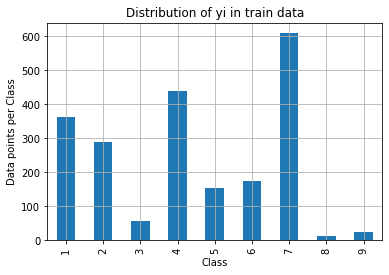

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


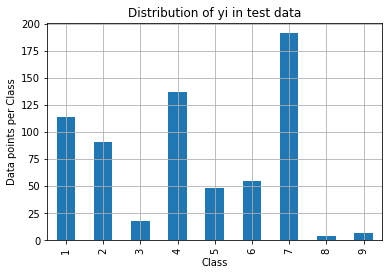

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


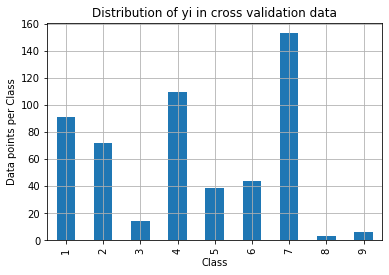

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h1> <font color=blue> Observations </font></h1>

- Since we have split the dataset by random so the distribution of classes in Train, Test and Cv is nearly the same.
- The given dataset is highly imbalance dataset.
- The dataset have classes 7, 4, 1 and 2 as majority classes
- The dataset have classes 3, 4, 8, 9 as minority classes

<h2> Deciding worst multiclass log-loss using a Random model </h2>

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    """
    This function plots the confusion matrices given y_i, y_i_hat
    """
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T) / (C.sum(axis = 1))).T)
    B =(C / C.sum(axis = 0))
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(C, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(B, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize = (20,7))
    sns.heatmap(A, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.493197325756756
Log loss on Test Data using Random Model 2.471926090812876
-------------------- Confusion matrix --------------------


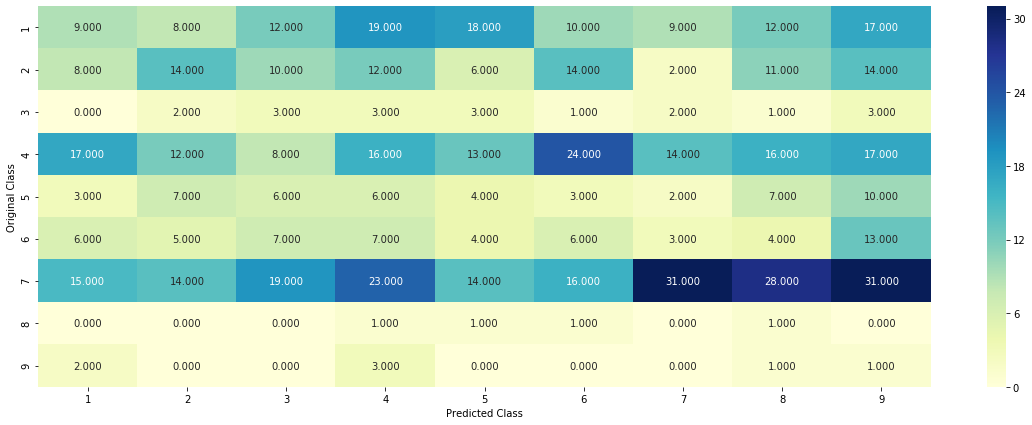

-------------------- Precision matrix (Columm Sum=1) --------------------


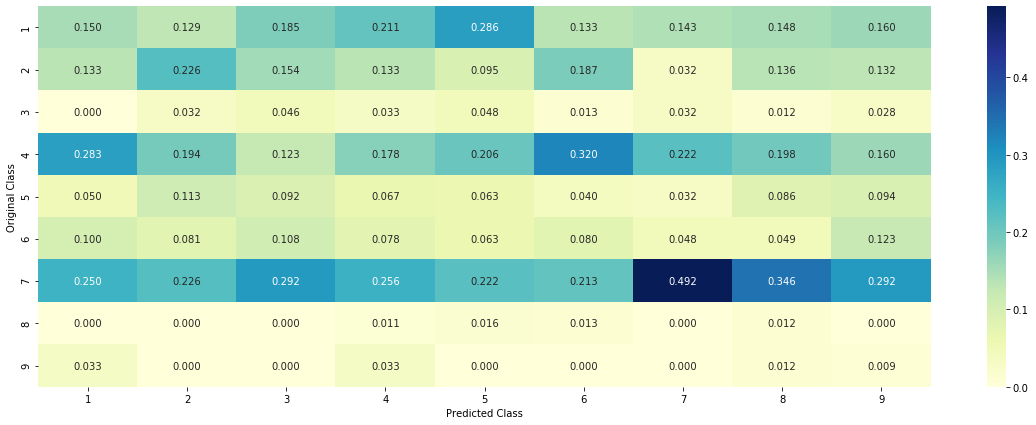

-------------------- Recall matrix (Row sum=1) --------------------


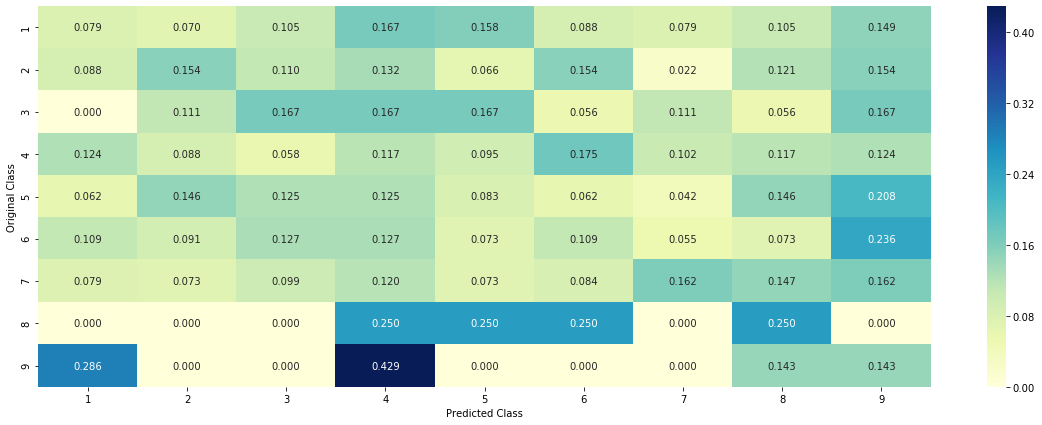

In [15]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h1> <font color=blue> Observations </font></h1>

- As we can see from the Random model the worst multiclass log loss for this problem is 2.47.
- The model that we build should have the log loss below 2.47.

<h2> Univariate Analysis</h2>

In [16]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

<h2>Univariate Analysis on Gene Feature</h2>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [17]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 221
BRCA1     172
TP53       98
EGFR       84
BRCA2      82
PTEN       79
KIT        70
BRAF       63
ALK        48
ERBB2      46
PIK3CA     38
Name: Gene, dtype: int64


In [18]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 221 different categories of genes in the train data, and they are distibuted as follows


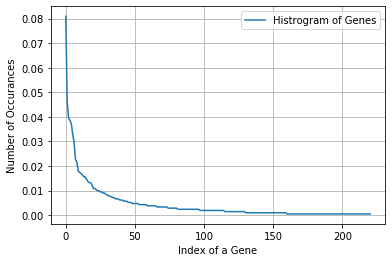

In [19]:
s = sum(unique_genes.values)
h = unique_genes.values/s

plt.plot(h, label = "Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

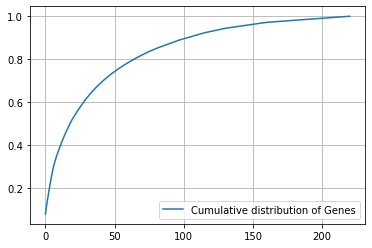

In [20]:
c = np.cumsum(h)
plt.plot(c, label = 'Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [21]:
alpha = 1

train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [22]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [23]:
# one-hot encoding of Gene feature

gene_vectorizer = CountVectorizer()

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [24]:
train_df['Gene'].head()

1235     PIM1
1947    MEF2B
349      CDH1
1293     HRAS
1523      ALK
Name: Gene, dtype: object

In [25]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'jak1',
 'jak2',
 'jun',
 'kdm5a',


In [26]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 220)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2519727022733864
For values of alpha =  0.0001 The log loss is: 1.2374780120880384
For values of alpha =  0.001 The log loss is: 1.2765209731105742
For values of alpha =  0.01 The log loss is: 1.3826951230597384
For values of alpha =  0.1 The log loss is: 1.4738753485882086
For values of alpha =  1 The log loss is: 1.5129240427028416


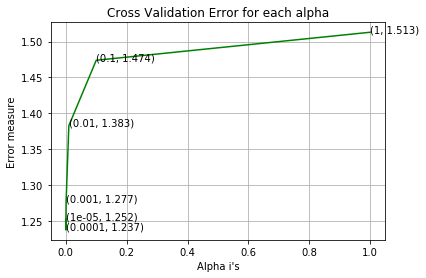

For values of best alpha =  0.0001 The train log loss is: 0.9801066159682027
For values of best alpha =  0.0001 The cross validation log loss is: 1.2374780120880384
For values of best alpha =  0.0001 The test log loss is: 1.1825686001504472


In [27]:
# Checking How much important is gene feature in prediction the y_i
# Applying simple lR with calibrated Classifier

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c = 'g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [28]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  221  genes in train dataset?
Ans
1. In test data 638 out of 665 : 95.93984962406014
2. In cross validation data 508 out of  532 : 95.48872180451127


<h1> <font color=blue> Observations </font> </h1>

- As we can see that alone gene feature has reduced the log loss from 2.47 to 1.18.
- Which is a significant reduction.
- Gene feature is important.

<h3> Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [29]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1936
Truncating_Mutations    54
Deletion                47
Amplification           44
Fusions                 19
G12V                     4
Overexpression           4
Q61H                     3
E330K                    2
G13D                     2
EWSR1-ETV1_Fusion        2
Name: Variation, dtype: int64


In [30]:
print("Ans: There are", unique_variations.shape[0] , "different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1936 different categories of variations in the train data, and they are distibuted as follows


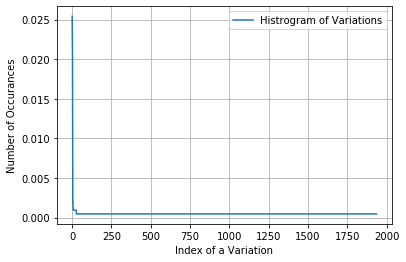

In [31]:
s = sum(unique_variations.values);
h = unique_variations.values / s;

plt.plot(h, label = "Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02542373 0.04755179 0.06826742 ... 0.99905838 0.99952919 1.        ]


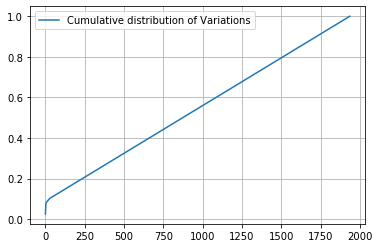

In [32]:
c = np.cumsum(h)
print(c)
plt.plot(c, label = 'Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [33]:
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [34]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [35]:
# one-hot encoding of variation feature.

variation_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [36]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1965)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

For values of alpha =  1e-05 The log loss is: 1.7113269971790552
For values of alpha =  0.0001 The log loss is: 1.7057748031123203
For values of alpha =  0.001 The log loss is: 1.702867177640526
For values of alpha =  0.01 The log loss is: 1.706417070080605
For values of alpha =  0.1 The log loss is: 1.714480832584981
For values of alpha =  1 The log loss is: 1.7148138892068714


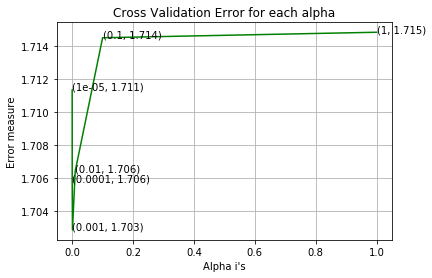

For values of best alpha =  0.001 The train log loss is: 1.0955372575095133
For values of best alpha =  0.001 The cross validation log loss is: 1.702867177640526
For values of best alpha =  0.001 The test log loss is: 1.6993409173046865


In [37]:
# As earlier buildind a simple Logistic Regression Model with Calibrated Classifer for variation feature

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')

for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [38]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans: 1. In test data',test_coverage, 'out of', test_df.shape[0], ":", (test_coverage / test_df.shape[0]) * 100)
print('\t2. In cross validation data',cv_coverage, 'out of ', cv_df.shape[0], ":" , (cv_coverage / cv_df.shape[0]) * 100)

Q12. How many data points are covered by total  1936  genes in test and cross validation data sets?
Ans: 1. In test data 75 out of 665 : 11.278195488721805
	2. In cross validation data 57 out of  532 : 10.714285714285714


<h1> <font color=blue> Observations </font> </h1>

- By using only variation feature the log loss is reduced to 1.70.
- The loss is not reduced as much as it reduced in gene feature.
- Also the variotions in test and CV data is very different from the training.
- Variation feature is important but not as much as gene feature.

<h2> Univariate Analysis on Text Feature</h2>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [39]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [40]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
                
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
            
    return text_feature_responseCoding

In [41]:
text_vectorizer = CountVectorizer(min_df=3)

train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53760


In [42]:
dict_list = []

for i in range(1,10):
    cls_text = train_df[train_df['Class'] == i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(train_df)
confuse_array = []

for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i] + 10 ) / (total_dict[i] + 90))
    confuse_array.append(ratios)

confuse_array = np.array(confuse_array)

In [43]:
# Response coding of text features

train_text_feature_responseCoding = get_text_responsecoding(train_df)
test_text_feature_responseCoding = get_text_responsecoding(test_df)
cv_text_feature_responseCoding = get_text_responsecoding(cv_df)

In [44]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T / train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T / test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T / cv_text_feature_responseCoding.sum(axis=1)).T

In [45]:
# Normalizing

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [46]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [47]:
# Number of words for a given frequency

print(Counter(sorted_text_occur))

Counter({3: 5833, 4: 3805, 5: 2809, 6: 2693, 8: 1997, 7: 1987, 9: 1802, 10: 1653, 12: 1180, 13: 1166, 11: 1101, 14: 988, 15: 968, 16: 731, 18: 667, 20: 579, 17: 576, 19: 534, 24: 531, 21: 499, 22: 444, 25: 431, 30: 412, 28: 409, 23: 396, 27: 366, 26: 352, 45: 334, 52: 295, 32: 295, 29: 278, 33: 261, 36: 257, 31: 255, 35: 253, 40: 239, 34: 238, 42: 232, 39: 213, 38: 210, 37: 193, 44: 190, 41: 181, 51: 157, 56: 156, 54: 156, 48: 156, 57: 154, 55: 154, 47: 149, 60: 143, 50: 142, 43: 137, 46: 135, 49: 134, 69: 123, 53: 121, 63: 118, 58: 118, 61: 113, 62: 109, 64: 107, 59: 107, 70: 104, 67: 103, 72: 100, 75: 98, 65: 96, 68: 94, 84: 93, 71: 90, 81: 89, 90: 88, 66: 88, 76: 86, 78: 85, 80: 81, 77: 79, 74: 74, 87: 73, 93: 72, 82: 72, 73: 72, 88: 71, 108: 67, 105: 67, 91: 66, 86: 61, 98: 60, 95: 60, 85: 60, 104: 59, 96: 58, 92: 58, 79: 56, 100: 55, 99: 53, 89: 53, 126: 52, 106: 52, 103: 52, 120: 51, 112: 51, 94: 50, 83: 49, 109: 47, 117: 46, 111: 46, 110: 46, 113: 45, 134: 43, 131: 43, 121: 43, 

For values of alpha =  1e-05 The log loss is: 1.329895889274032
For values of alpha =  0.0001 The log loss is: 1.1859995431340724
For values of alpha =  0.001 The log loss is: 1.1816334571051037
For values of alpha =  0.01 The log loss is: 1.2966899246580765
For values of alpha =  0.1 The log loss is: 1.460785675755051
For values of alpha =  1 The log loss is: 1.6594970984852093


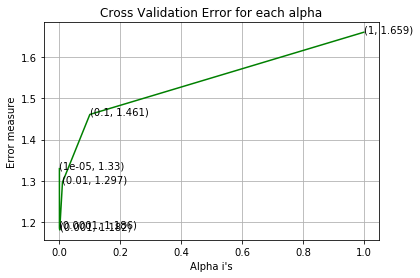

For values of best alpha =  0.001 The train log loss is: 0.6610459690042393
For values of best alpha =  0.001 The cross validation log loss is: 1.1816334571051037
For values of best alpha =  0.001 The test log loss is: 1.1118017728174392


In [48]:
# Training a simple LR model with Calibrated Classifier

alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [49]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [50]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")

len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.259 % of word of test data appeared in train data
98.575 % of word of Cross Validation appeared in train data


<h1> <font color=blue> Observations </font> </h1>

- By only using Text feature the log loss that we have obtained is 1.11.
- The achieved log loss is quite satisfactory given that it is obtained by using only 1 feature.
- Text feature is very important feature.

<h1>Applying Machine Learning Models</h1>

In [51]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    
    plot_confusion_matrix(test_y, pred_y)

In [52]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [53]:
# For Naive Bayes to get the names of important features

def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Stacking the three types of features

In [54]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [55]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55945)
(number of data points * number of features) in test data =  (665, 55945)
(number of data points * number of features) in cross validation data = (532, 55945)


In [56]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>Base Line Model (Naive Bayes) </h2>

<h3>Hyper parameter tuning</h3>

for alpha = 1e-05
Log Loss : 1.278789308662036
for alpha = 0.0001
Log Loss : 1.2773334660840903
for alpha = 0.001
Log Loss : 1.2751858062794428
for alpha = 0.1
Log Loss : 1.2570026607894458
for alpha = 1
Log Loss : 1.2909053900365035
for alpha = 10
Log Loss : 1.4006459403253997
for alpha = 100
Log Loss : 1.3825815823707301
for alpha = 1000
Log Loss : 1.3166146503891014


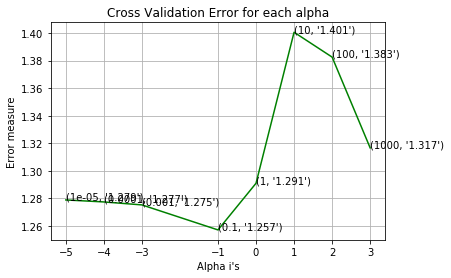

For values of best alpha =  0.1 The train log loss is: 0.8601148179488521
For values of best alpha =  0.1 The cross validation log loss is: 1.2570026607894458
For values of best alpha =  0.1 The test log loss is: 1.2706871237769615


In [57]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3> Testing the model with best hyper paramters</h3>

Log Loss : 1.2570026607894458
Number of missclassified point : 0.39285714285714285
-------------------- Confusion matrix --------------------


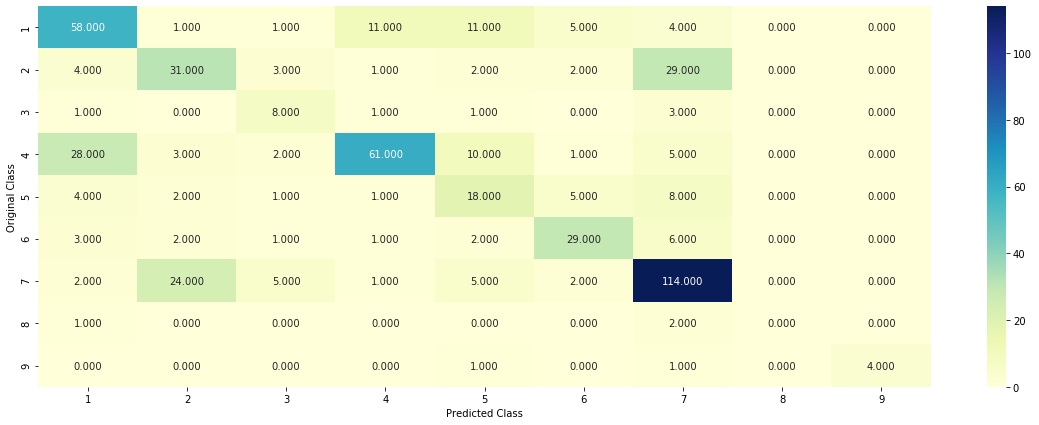

-------------------- Precision matrix (Columm Sum=1) --------------------


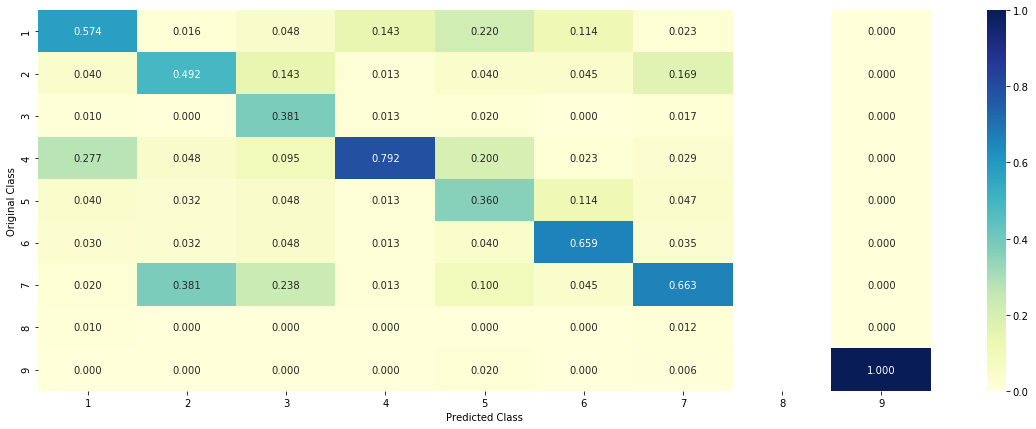

-------------------- Recall matrix (Row sum=1) --------------------


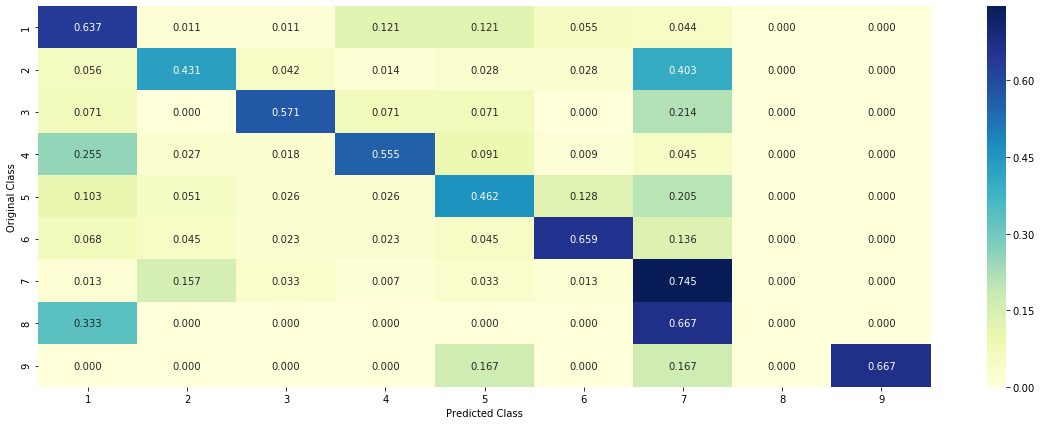

In [58]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h1> <font color=blue> Observations </font></h1>

- Naive bayes is used to act as a baseline model.
- The best alpha value is 0.1.
- The test log loss by Naive Bayes is 1.27.
- Number of misclassified points are 0.3928.

<h3> Feature Importance and Incorrectly classified point</h3>

In [59]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1099 0.0991 0.02   0.1291 0.4223 0.0445 0.164  0.0065 0.0047]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h3> Feature Importance and Correctly classified point</h3>

In [60]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0738 0.0668 0.0136 0.6666 0.0311 0.0299 0.1106 0.0044 0.0032]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


<h2> K Nearest Neighbour </h2>

<h3>Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.1357652321631344
for alpha = 11
Log Loss : 1.130503241033282
for alpha = 15
Log Loss : 1.1209391702665708
for alpha = 21
Log Loss : 1.1156120292159917
for alpha = 31
Log Loss : 1.1295146852427798
for alpha = 41
Log Loss : 1.142443217443858
for alpha = 51
Log Loss : 1.1414654470118355
for alpha = 99
Log Loss : 1.1695959172670027


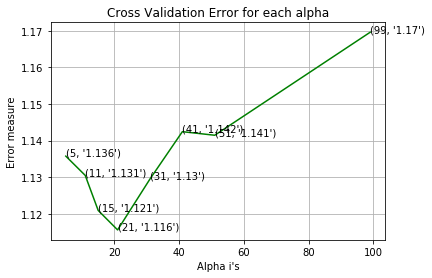

For values of best alpha =  21 The train log loss is: 0.7253976058071508
For values of best alpha =  21 The cross validation log loss is: 1.1156120292159917
For values of best alpha =  21 The test log loss is: 1.0704282254037798


In [61]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.1156120292159917
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


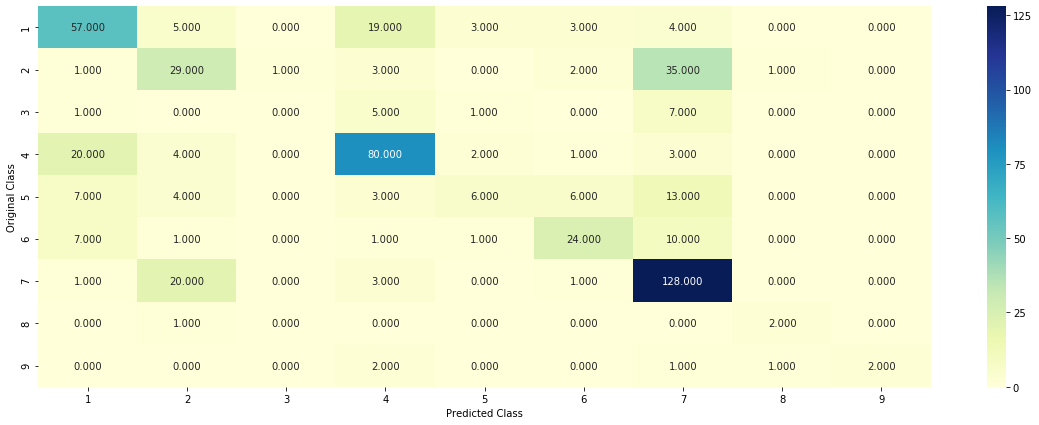

-------------------- Precision matrix (Columm Sum=1) --------------------


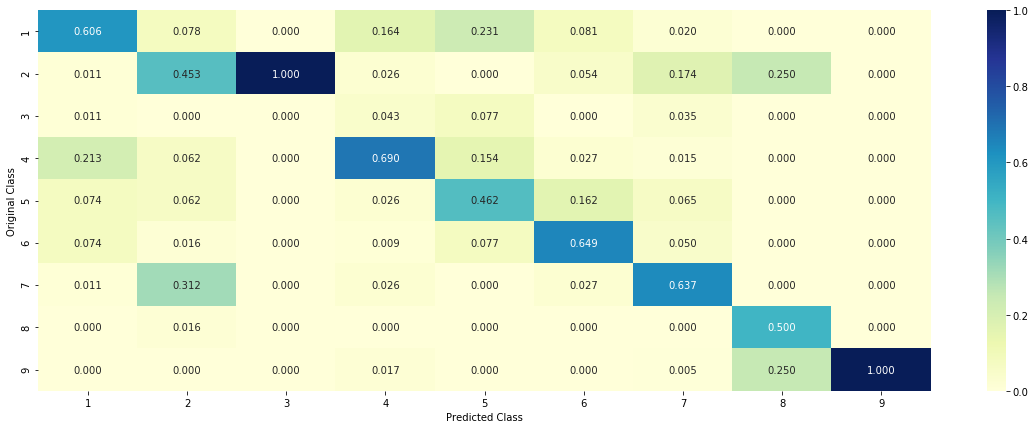

-------------------- Recall matrix (Row sum=1) --------------------


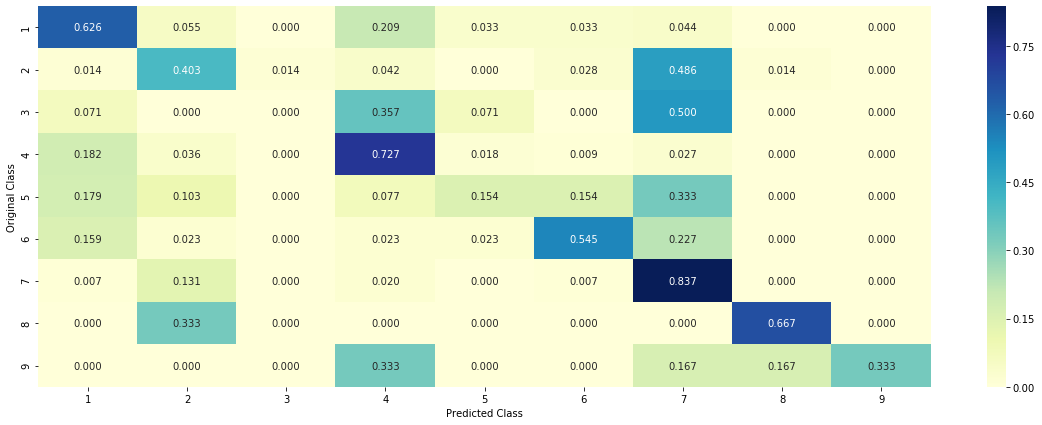

In [62]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best k value is 21.
- The test log loss by KNN is 1.07.
- Number of misclassified points are 0.3834.

<h3>Sample Query point -1</h3>

In [63]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  21  nearest neighbours of the test points belongs to classes [4 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Fequency of nearest points : Counter({4: 19, 5: 2})


<h3> Sample Query Point-2 </h3>

In [64]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 21 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 1 1 4 1 1]
Fequency of nearest points : Counter({4: 16, 1: 5})


<h2> Logistic Regression with Class Balancing</h2>

<h3> Hyper paramter tuning</h3>

for alpha = 1e-06
Log Loss : 1.326432795336554
for alpha = 1e-05
Log Loss : 1.2798927652974355
for alpha = 0.0001
Log Loss : 1.1535032325228216
for alpha = 0.001
Log Loss : 1.1095056949197042
for alpha = 0.01
Log Loss : 1.1506878474795372
for alpha = 0.1
Log Loss : 1.4280019184853032
for alpha = 1
Log Loss : 1.6462182202823852
for alpha = 10
Log Loss : 1.6779805889841999
for alpha = 100
Log Loss : 1.6813973895784946


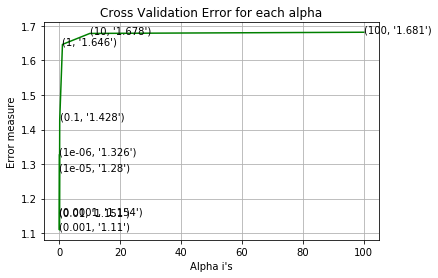

For values of best alpha =  0.001 The train log loss is: 0.5391990465545016
For values of best alpha =  0.001 The cross validation log loss is: 1.1095056949197042
For values of best alpha =  0.001 The test log loss is: 1.0431542345531812


In [65]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.1095056949197042
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


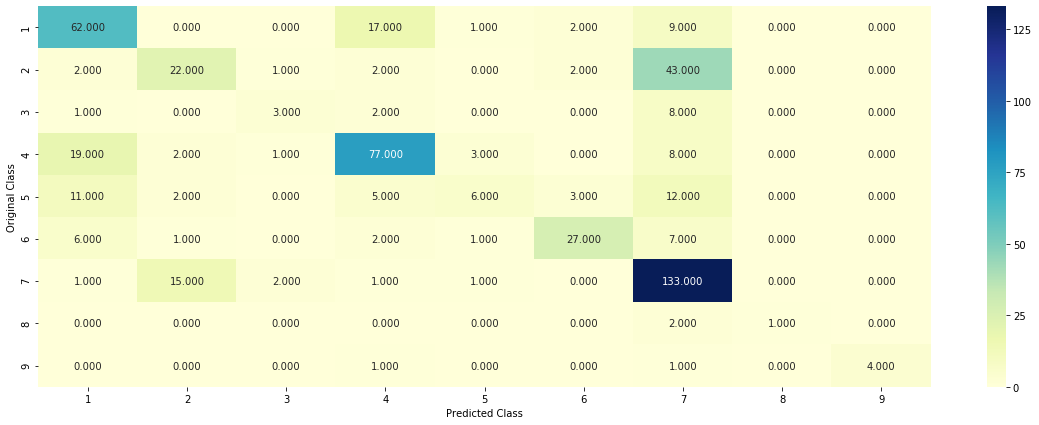

-------------------- Precision matrix (Columm Sum=1) --------------------


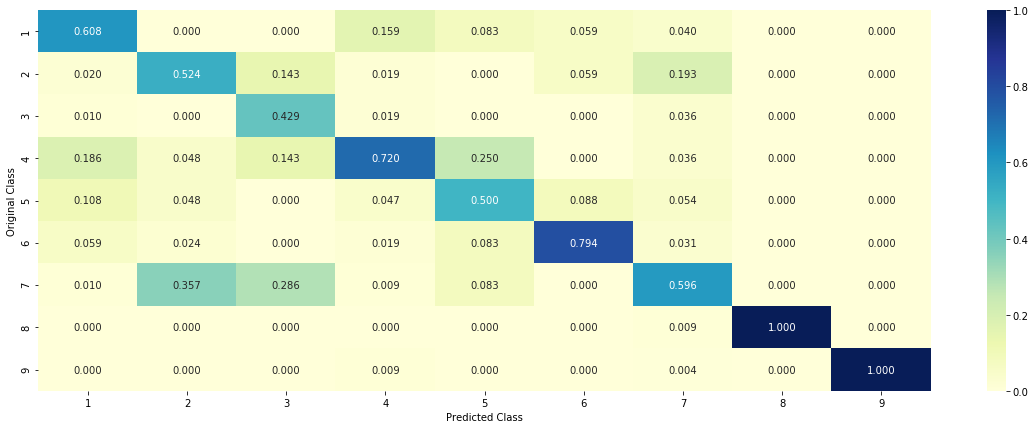

-------------------- Recall matrix (Row sum=1) --------------------


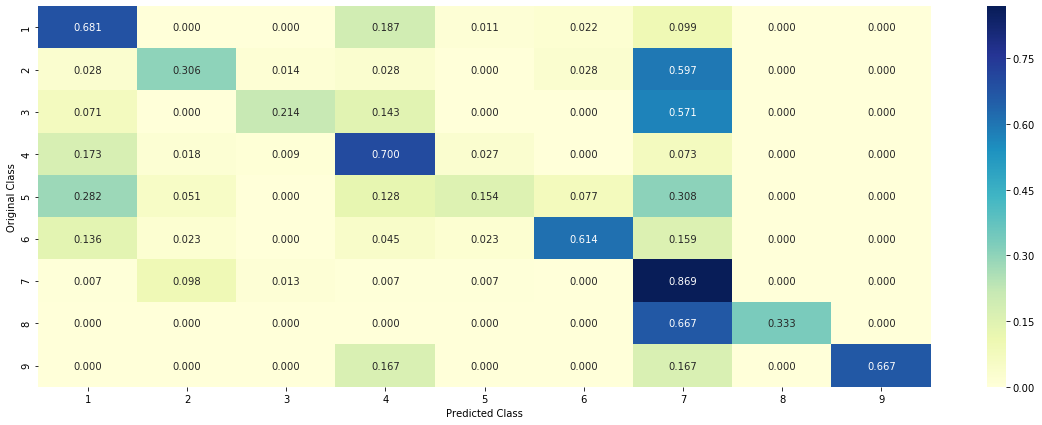

In [66]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.001.
- The test log loss by Logistic Regression with class balancing is 1.04.
- Number of misclassified points are 0.3703.

<h3>Feature Importance</h3>

In [67]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h3> Incorrectly Classified point</h3>

In [68]:
# from tabulate import tabulate

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0554 0.07   0.013  0.2576 0.5014 0.022  0.0665 0.007  0.0071]]
Actual Class : 4
--------------------------------------------------
252 Text feature [pyrimidines] present in test data point [True]
368 Text feature [s362l] present in test data point [True]
369 Text feature [p95s] present in test data point [True]
370 Text feature [ezviewtm] present in test data point [True]
371 Text feature [901g] present in test data point [True]
372 Text feature [cycloadenines] present in test data point [True]
373 Text feature [l325f] present in test data point [True]
374 Text feature [f154l] present in test data point [True]
375 Text feature [d301n] present in test data point [True]
376 Text feature [pyrimidone] present in test data point [True]
377 Text feature [dermatoscopy] present in test data point [True]
378 Text feature [xp295be] present in test data point [True]
379 Text feature [y16x] present in test data point [True]
380 Text feature [2

<h3> Correctly Classified point</h3>

In [69]:
test_point_index = 100
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0163 0.0282 0.0065 0.8825 0.0146 0.0104 0.0335 0.0045 0.0036]]
Actual Class : 4
--------------------------------------------------
170 Text feature [activating] present in test data point [True]
188 Text feature [nonidet] present in test data point [True]
290 Text feature [destroyed] present in test data point [True]
329 Text feature [transforming] present in test data point [True]
380 Text feature [inhibitor] present in test data point [True]
382 Text feature [agar] present in test data point [True]
386 Text feature [potential] present in test data point [True]
476 Text feature [confer] present in test data point [True]
495 Text feature [constitutive] present in test data point [True]
Out of the top  500  features  9 are present in query point


<h2> Logistic Regression Without Class balancing</h2>

<h3>Hyper paramter tuning</h3>

for alpha = 1e-06
Log Loss : 1.3211661228932872
for alpha = 1e-05
Log Loss : 1.283642052262818
for alpha = 0.0001
Log Loss : 1.1636121845687155
for alpha = 0.001
Log Loss : 1.128608762507809
for alpha = 0.01
Log Loss : 1.223710593498229
for alpha = 0.1
Log Loss : 1.3805451890253693
for alpha = 1
Log Loss : 1.6107660073579224


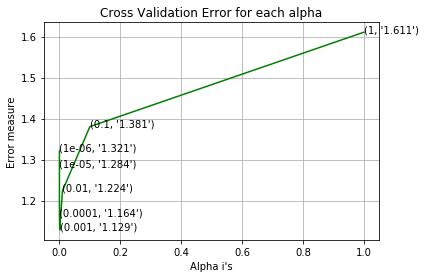

For values of best alpha =  0.001 The train log loss is: 0.5349039849019852
For values of best alpha =  0.001 The cross validation log loss is: 1.128608762507809
For values of best alpha =  0.001 The test log loss is: 1.045002355161908


In [70]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.128608762507809
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


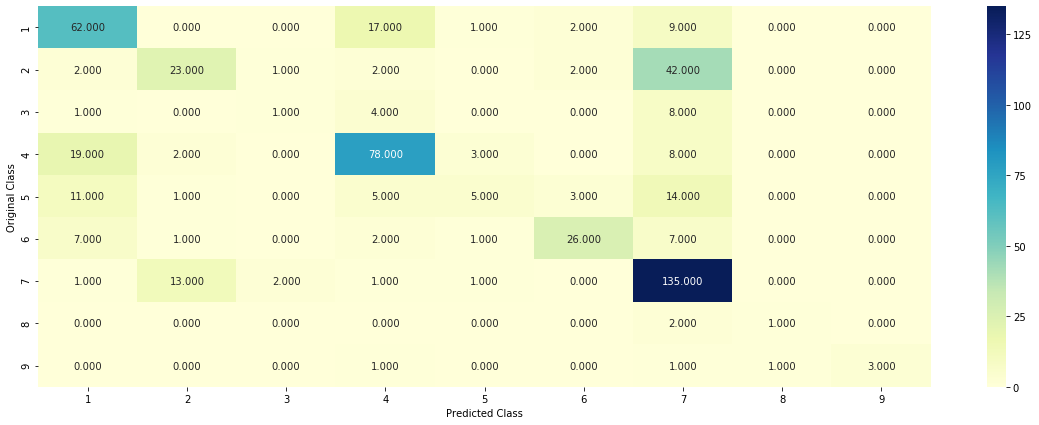

-------------------- Precision matrix (Columm Sum=1) --------------------


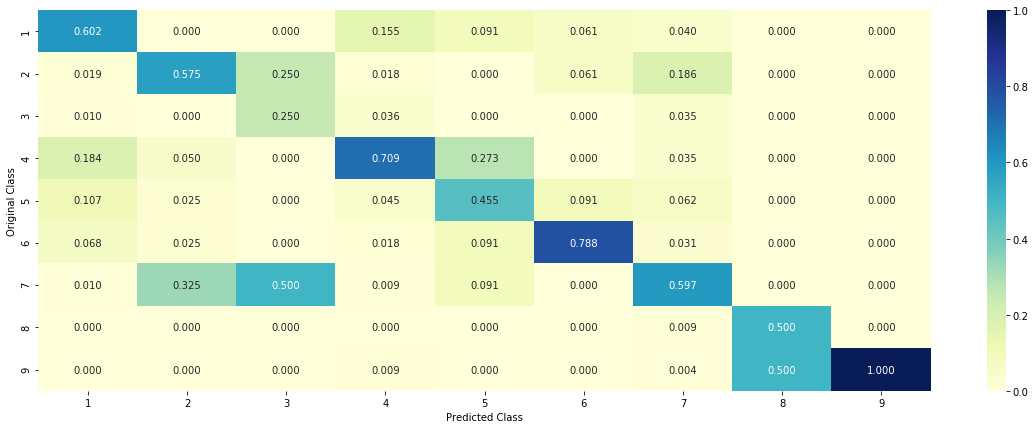

-------------------- Recall matrix (Row sum=1) --------------------


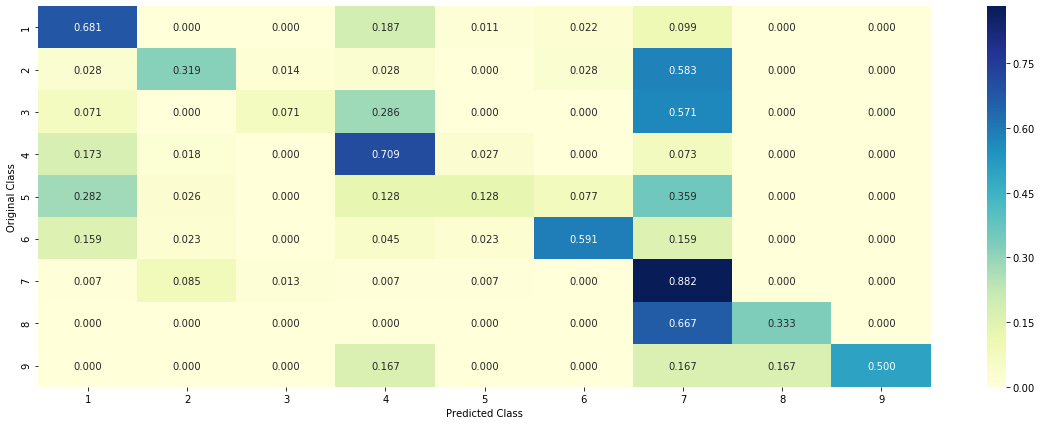

In [71]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.001.
- The test log loss by Logistic Regression without class balancing is 1.05.
- Number of misclassified points are 0.3721.
- As we can see that the difference between the test logloss and No. of misclassified points between LR with and without class balancing is not that much. Infact they are nearly the same!

<h3> Feature Importance and Incorrectly Classified point</h3>

In [72]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0557 0.0708 0.0149 0.2956 0.4639 0.0223 0.0653 0.0059 0.0057]]
Actual Class : 4
--------------------------------------------------
262 Text feature [pyrimidines] present in test data point [True]
375 Text feature [identified] present in test data point [True]
411 Text feature [identification] present in test data point [True]
429 Text feature [ezviewtm] present in test data point [True]
430 Text feature [q110r] present in test data point [True]
431 Text feature [292c] present in test data point [True]
432 Text feature [p95s] present in test data point [True]
433 Text feature [f154l] present in test data point [True]
434 Text feature [pyrimidone] present in test data point [True]
435 Text feature [g230x] present in test data point [True]
436 Text feature [cycloadenines] present in test data point [True]
437 Text feature [dermatoscopy] present in test data point [True]
438 Text feature [901g] present in test data point [True]
439 Tex

<h3>Feature Importance and Correctly Classified point</h3>

In [73]:
test_point_index = 100
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0168 0.0287 0.0066 0.8819 0.0147 0.0101 0.0355 0.0036 0.0022]]
Actual Class : 4
--------------------------------------------------
310 Text feature [activating] present in test data point [True]
315 Text feature [nonidet] present in test data point [True]
389 Text feature [destroyed] present in test data point [True]
Out of the top  500  features  3 are present in query point


<h2> Linear Support Vector Machines</h2>

<h3> Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.309993141366402
for C = 0.0001
Log Loss : 1.2573809143397818
for C = 0.001
Log Loss : 1.146413204671599
for C = 0.01
Log Loss : 1.1602749625278517
for C = 0.1
Log Loss : 1.382856169130563
for C = 1
Log Loss : 1.6637737731226172
for C = 10
Log Loss : 1.6819950886866328
for C = 100
Log Loss : 1.6819944440896757


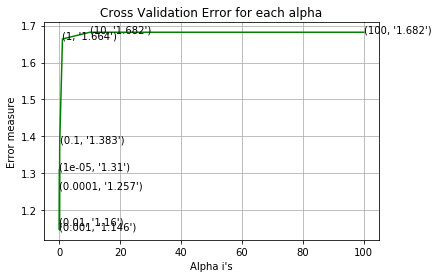

For values of best alpha =  0.001 The train log loss is: 0.5624840214507419
For values of best alpha =  0.001 The cross validation log loss is: 1.146413204671599
For values of best alpha =  0.001 The test log loss is: 1.1191231771652232


In [74]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.146413204671599
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


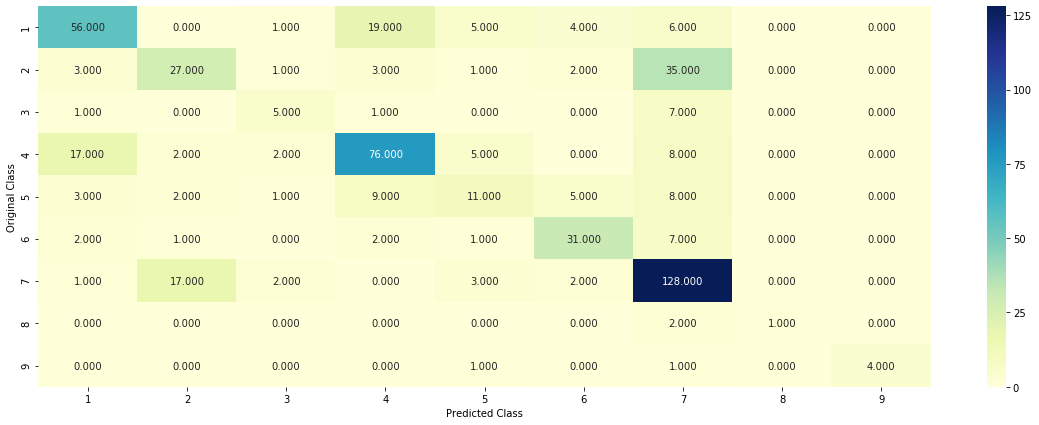

-------------------- Precision matrix (Columm Sum=1) --------------------


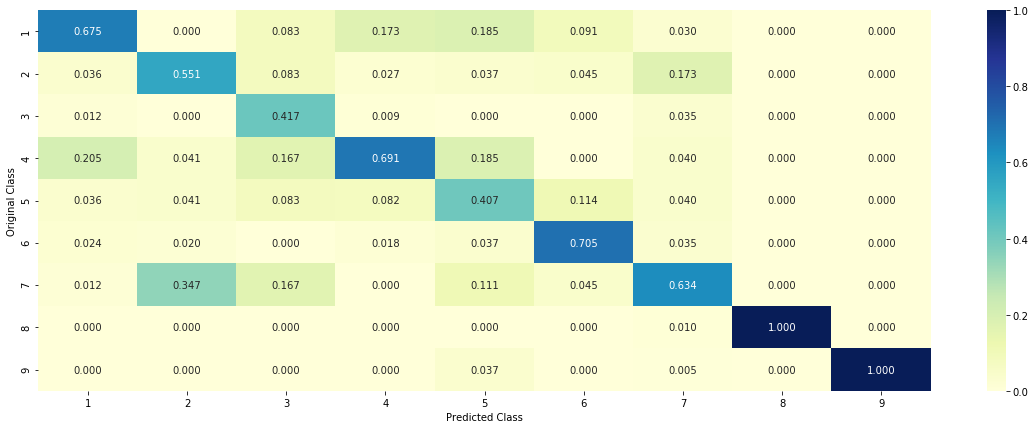

-------------------- Recall matrix (Row sum=1) --------------------


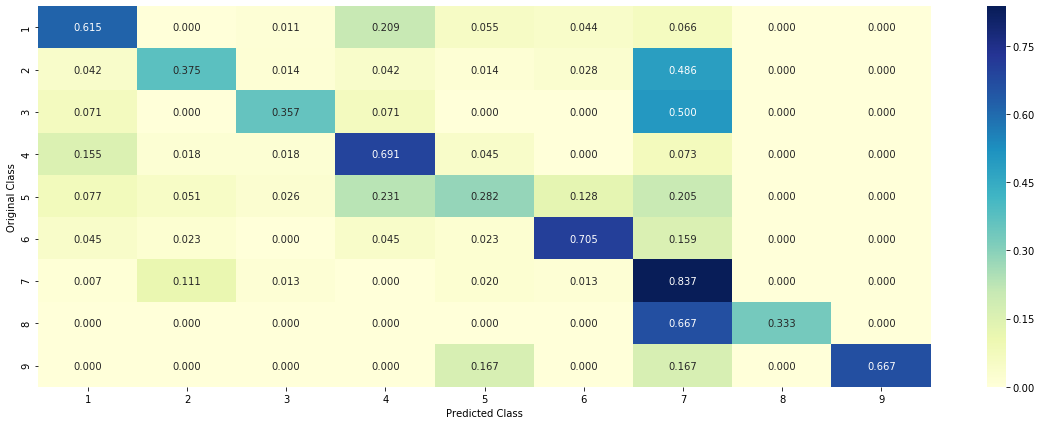

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.001.
- The test log loss by Linear SVM is 1.11.
- Number of misclassified points are 0.3627.

<h3> Feature Importance</h3>

<h4> For Incorrectly classified point</h4>

In [76]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.104  0.0858 0.0074 0.0491 0.5812 0.0362 0.123  0.0059 0.0073]]
Actual Class : 4
--------------------------------------------------
396 Text feature [pyrimidines] present in test data point [True]
483 Text feature [f154l] present in test data point [True]
484 Text feature [g230x] present in test data point [True]
485 Text feature [q110r] present in test data point [True]
486 Text feature [ezviewtm] present in test data point [True]
487 Text feature [d301n] present in test data point [True]
488 Text feature [pyrimidone] present in test data point [True]
489 Text feature [dermatoscopy] present in test data point [True]
490 Text feature [292c] present in test data point [True]
491 Text feature [y16x] present in test data point [True]
492 Text feature [p95s] present in test data point [True]
493 Text feature [xp295be] present in test data point [True]
494 Text feature [901g] present in test data point [True]
495 Text feature [cycloadeni

<h4> For Correctly classified point</h4>

In [77]:
test_point_index = 100
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0508 0.0503 0.0093 0.7377 0.0297 0.0192 0.0943 0.0046 0.0042]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h2>Random Forest Classifier</h2>

<h3> Hyper paramter tuning (With One hot Encoding)</h3>

In [78]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2614781130529913
for n_estimators = 100 and max depth =  10
Log Loss : 1.1876944571609138
for n_estimators = 200 and max depth =  5
Log Loss : 1.2482958045197232
for n_estimators = 200 and max depth =  10
Log Loss : 1.1769129889657957
for n_estimators = 500 and max depth =  5
Log Loss : 1.245557387176137
for n_estimators = 500 and max depth =  10
Log Loss : 1.1756940381917431
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2406928496150462
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1758533165036986
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2399040470536569
for n_estimators = 2000 and max depth =  10
Log Loss : 1.174706260788384
For values of best estimator =  2000 The train log loss is: 0.7048815084029313
For values of best estimator =  2000 The cross validation log loss is: 1.174706260788384
For values of best estimator =  2000 The test log loss is: 1.147870913318269


<h3> Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.174706260788384
Number of mis-classified points : 0.40225563909774437
-------------------- Confusion matrix --------------------


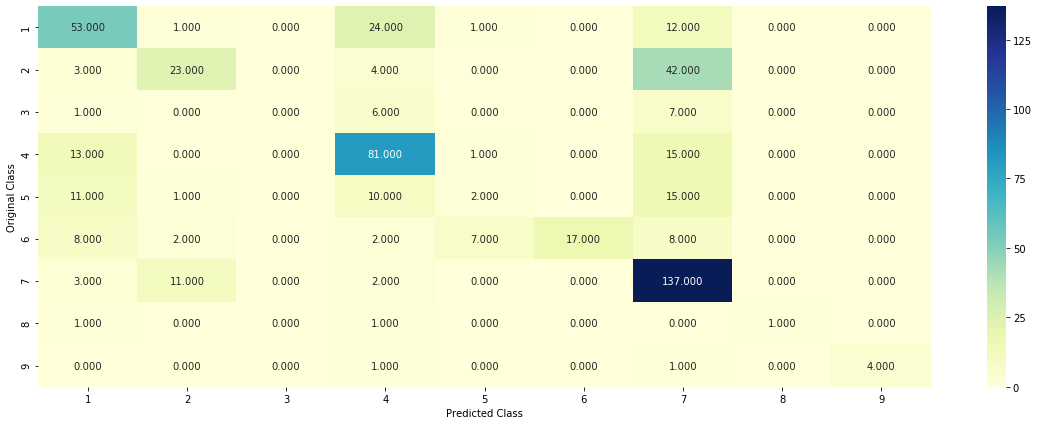

-------------------- Precision matrix (Columm Sum=1) --------------------


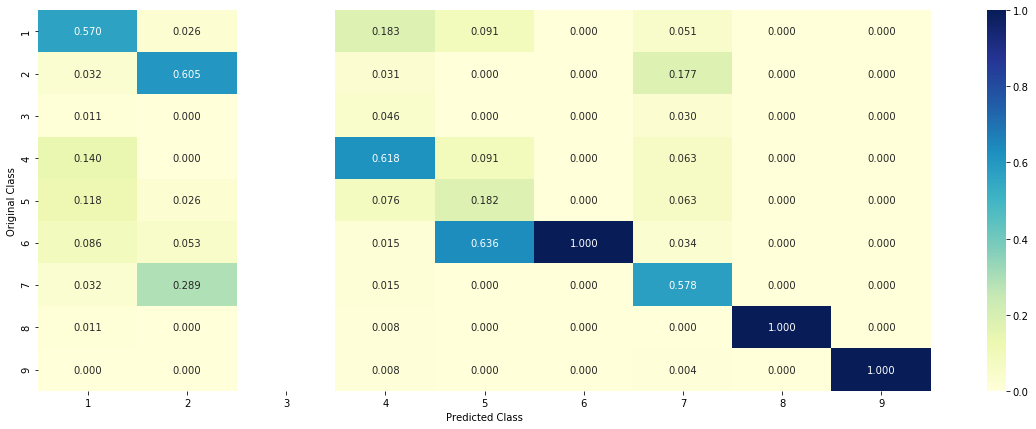

-------------------- Recall matrix (Row sum=1) --------------------


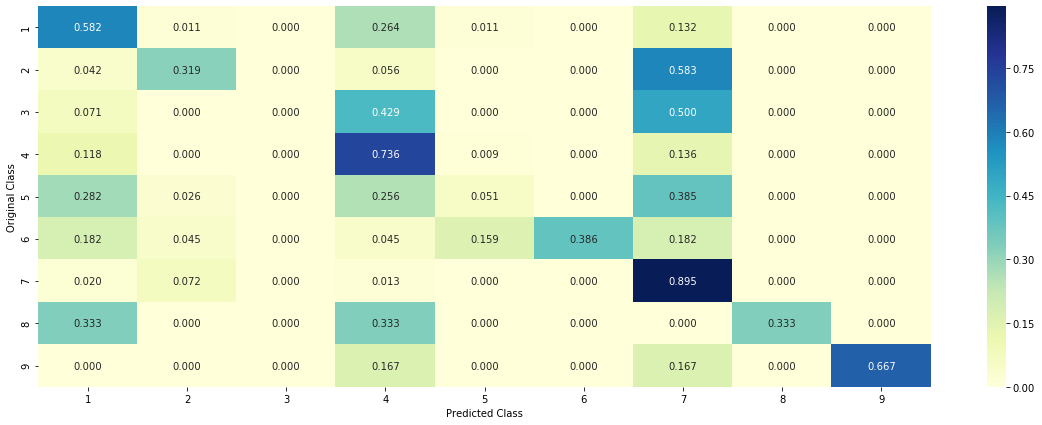

In [79]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 2000.
- The test log loss by Random Forest with one hot encoding is 1.14.
- Number of misclassified points are 0.4022.

<h3> Feature Importance</h3>

<h4> Correctly Classified point</h4>

In [80]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.2443 0.0892 0.0267 0.3931 0.0837 0.0551 0.0895 0.0079 0.0105]]
Actual Class : 4
--------------------------------------------------
5 Text feature [activation] present in test data point [True]
6 Text feature [missense] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
10 Text feature [nonsense] present in test data point [True]
11 Text feature [function] present in test data point [True]
13 Text feature [signaling] present in test data point [True]
14 Text feature [suppressor] present in test data point [True]
17 Text feature [akt] present in test data point [True]
18 Text feature [cells] present in test data point [True]
20 Text feature [functional] present in test data point [True]
24 Text feature [downstream] present in test data point [True]
25 Text feature [activate] present in test data point [True]
27 Text feature [loss] present in test data point [True]
49 Text feature [tre

<h4> Inorrectly Classified point</h4>

In [81]:
test_point_index = 100
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0909 0.075  0.0234 0.5344 0.0501 0.0436 0.1675 0.0067 0.0084]]
Actuall Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [constitutive] present in test data point [True]
5 Text feature [activation] present in test data point [True]
8 Text feature [phosphorylation] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
11 Text feature [function] present in test data point [True]
13 Text feature [signaling] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
17 Text feature [akt] present in test data point [True]
18 Text feature [cells] present in test data point [True]
19 Text feature [growth] present in test data point [True]
24 Text feature [do

<h2> Hyper paramter tuning (With Response Coding)</h2>

In [82]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0951197412987494
for n_estimators = 10 and max depth =  3
Log Loss : 1.8459073329166769
for n_estimators = 10 and max depth =  5
Log Loss : 1.4640726302908331
for n_estimators = 10 and max depth =  10
Log Loss : 1.8671169699107457
for n_estimators = 50 and max depth =  2
Log Loss : 1.7601527365056566
for n_estimators = 50 and max depth =  3
Log Loss : 1.4298518180852928
for n_estimators = 50 and max depth =  5
Log Loss : 1.3878405035939285
for n_estimators = 50 and max depth =  10
Log Loss : 1.6547657461129928
for n_estimators = 100 and max depth =  2
Log Loss : 1.5988238052400199
for n_estimators = 100 and max depth =  3
Log Loss : 1.4238119244704797
for n_estimators = 100 and max depth =  5
Log Loss : 1.4040224746019536
for n_estimators = 100 and max depth =  10
Log Loss : 1.6637290441571593
for n_estimators = 200 and max depth =  2
Log Loss : 1.616428709630442
for n_estimators = 200 and max depth =  3
Log Loss : 1.425751793730086

<h3> Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.3878405035939287
Number of mis-classified points : 0.5582706766917294
-------------------- Confusion matrix --------------------


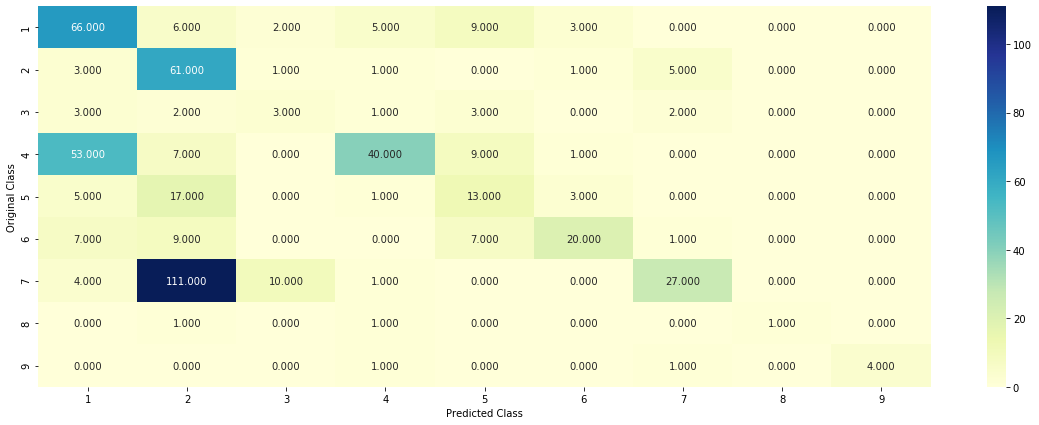

-------------------- Precision matrix (Columm Sum=1) --------------------


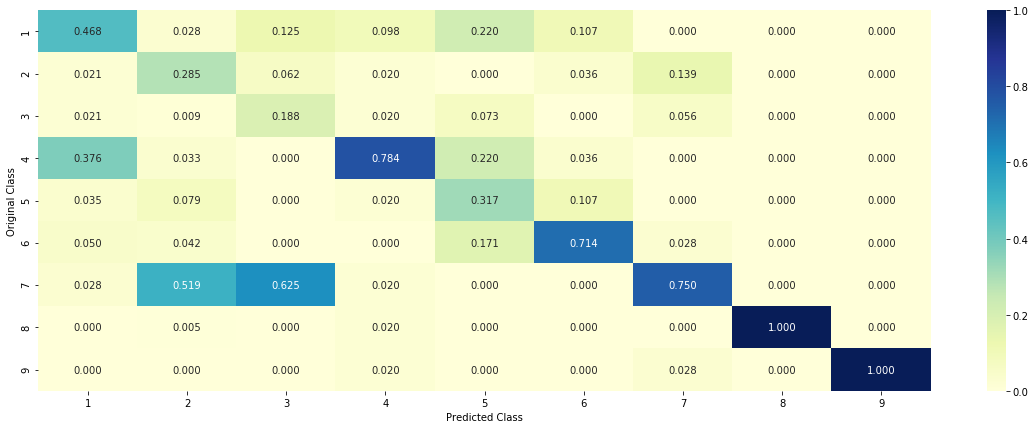

-------------------- Recall matrix (Row sum=1) --------------------


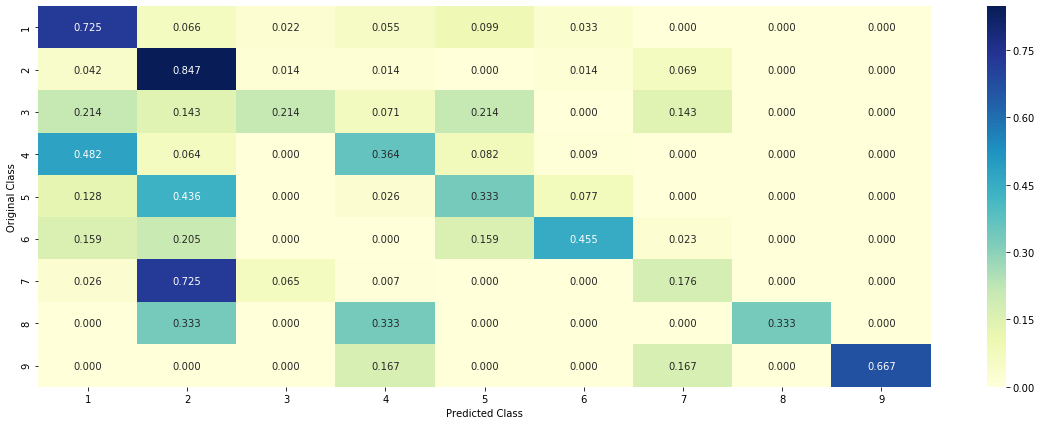

In [83]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 50.
- The test log loss by Random Forest with response coding is 1.30.
- Number of misclassified points are 0.5582.

<h3> Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [84]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.2577 0.0338 0.1334 0.3951 0.0638 0.0278 0.012  0.0372 0.0393]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature


<h4>Incorrectly Classified point</h4>

In [85]:
test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.3015 0.0584 0.128  0.3823 0.0357 0.0274 0.0151 0.0251 0.0265]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature


<h2>Stack the models </h2>

<h3> Testing with hyper parameter tuning</h3>

In [86]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.66
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.730
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.360
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.226
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.509
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.861


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.5129146629931494
Log loss (CV) on the stacking classifier : 1.2259620599474286
Log loss (test) on the stacking classifier : 1.1225525737461446
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


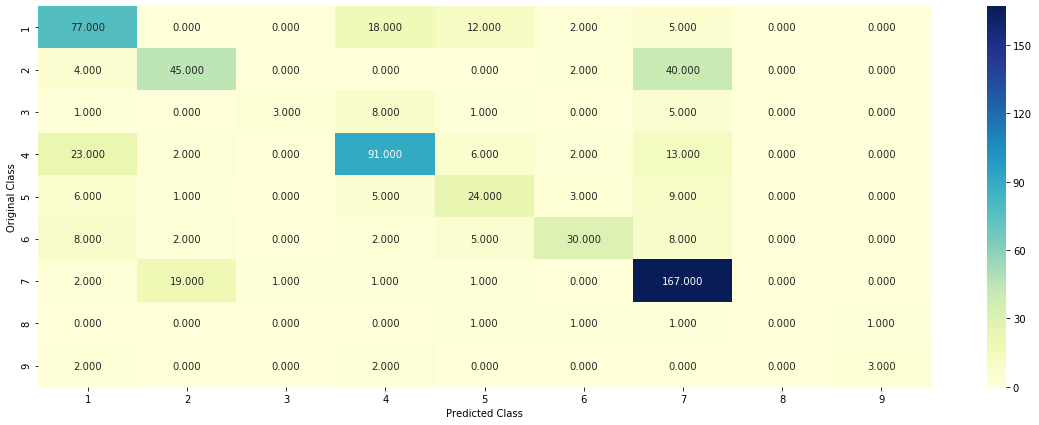

-------------------- Precision matrix (Columm Sum=1) --------------------


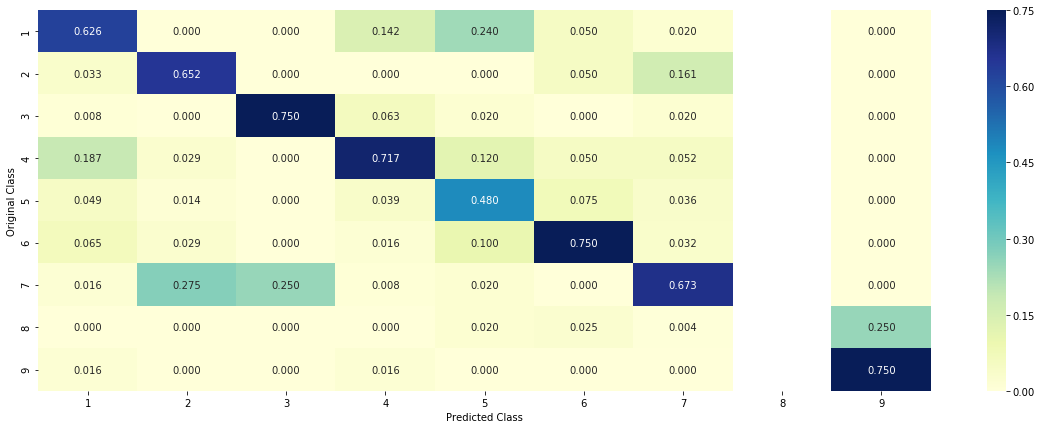

-------------------- Recall matrix (Row sum=1) --------------------


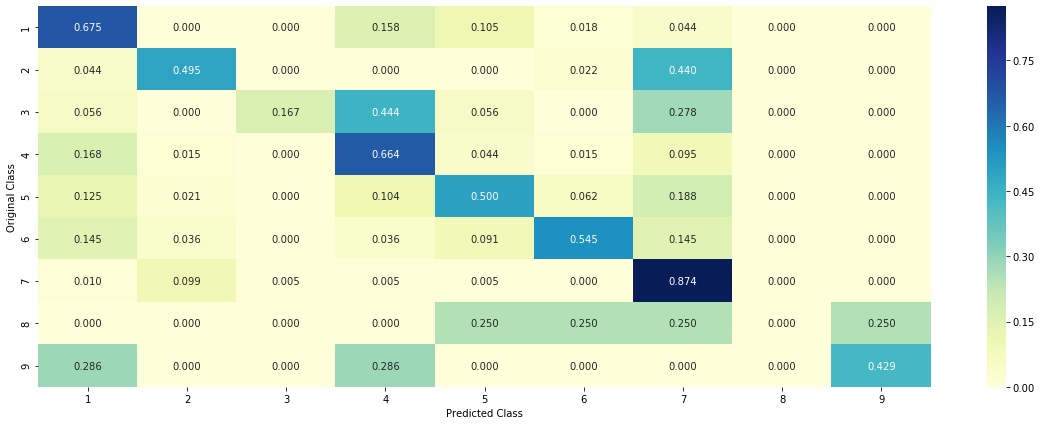

In [87]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.1.
- The test log loss by Stacking classifier is 1.12.
- Number of misclassified points are 0.3383.

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.875427852890204
Log loss (CV) on the VotingClassifier : 1.1992683082135023
Log loss (test) on the VotingClassifier : 1.1752829761856285
Number of missclassified point : 0.3458646616541353
-------------------- Confusion matrix --------------------


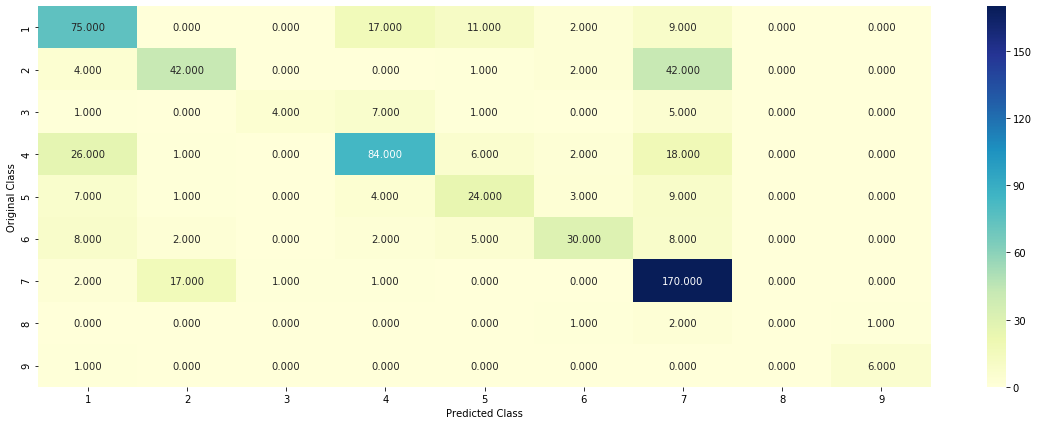

-------------------- Precision matrix (Columm Sum=1) --------------------


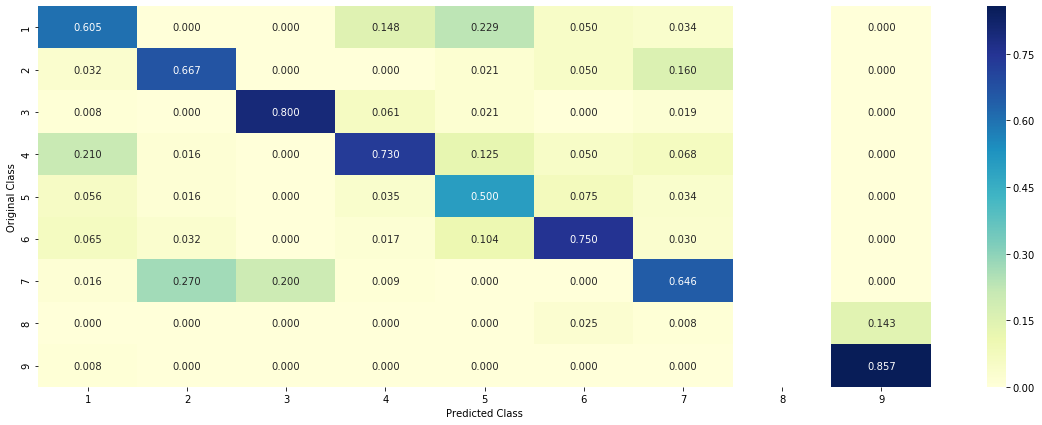

-------------------- Recall matrix (Row sum=1) --------------------


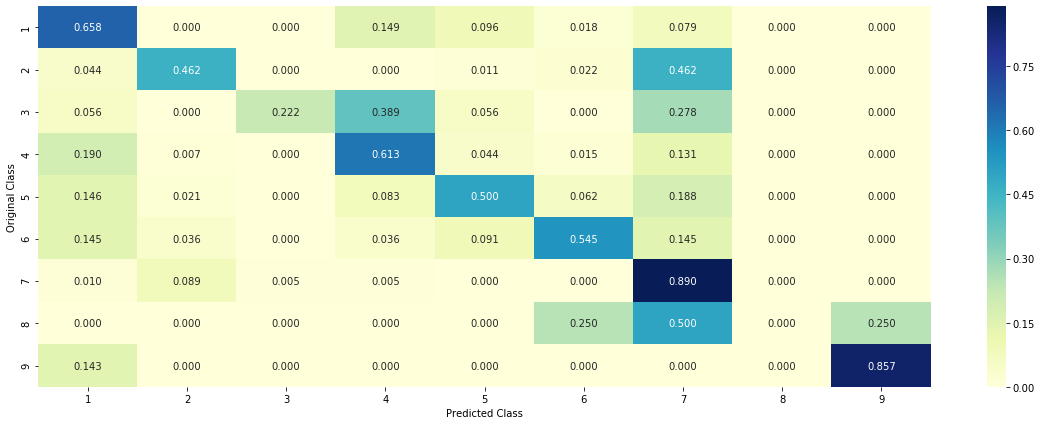

In [88]:
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])

plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

<h1> <font color=blue> Observations </font></h1>

- The test log loss by Majority voting classifier is 1.17.
- Number of misclassified points are 0.3458.

<h1> Task - 1 </h1>

<h2> Using Tf-idf features </h2>

In [109]:
text_vectorizer = TfidfVectorizer(min_df=3)

train_text_feature_tfidf = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features = text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53760


In [110]:
# Normalizing

train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

test_text_feature_tfidf = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)

# Merging all the features

In [111]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [112]:
# Checking total datapoints in Train, Test and CV

print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

(number of data points * number of features) in train data =  (2124, 55945)
(number of data points * number of features) in test data =  (665, 55945)
(number of data points * number of features) in cross validation data = (532, 55945)


# Applying Machine Learning models

## Naive Bayes

### Hyper parameter tuning

for alpha = 1e-05
Log Loss : 1.2769085836078728
for alpha = 0.0001
Log Loss : 1.2681795946092136
for alpha = 0.001
Log Loss : 1.2637916533089544
for alpha = 0.1
Log Loss : 1.2688212002951393
for alpha = 1
Log Loss : 1.2891207339825774
for alpha = 10
Log Loss : 1.3742185132101814
for alpha = 100
Log Loss : 1.2952490659818559
for alpha = 1000
Log Loss : 1.2399020375061882


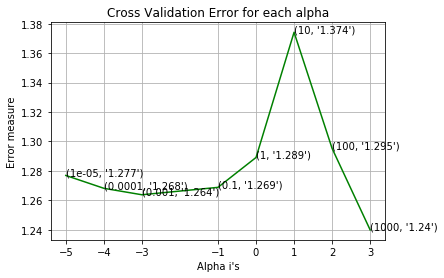

For values of best alpha =  1000 The train log loss is: 0.9220250222743688
For values of best alpha =  1000 The cross validation log loss is: 1.2399020375061882
For values of best alpha =  1000 The test log loss is: 1.1883733203351687


In [113]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))

plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing with best Hyper parameter

Log Loss : 1.2399020375061882
Number of missclassified point : 0.42857142857142855
-------------------- Confusion matrix --------------------


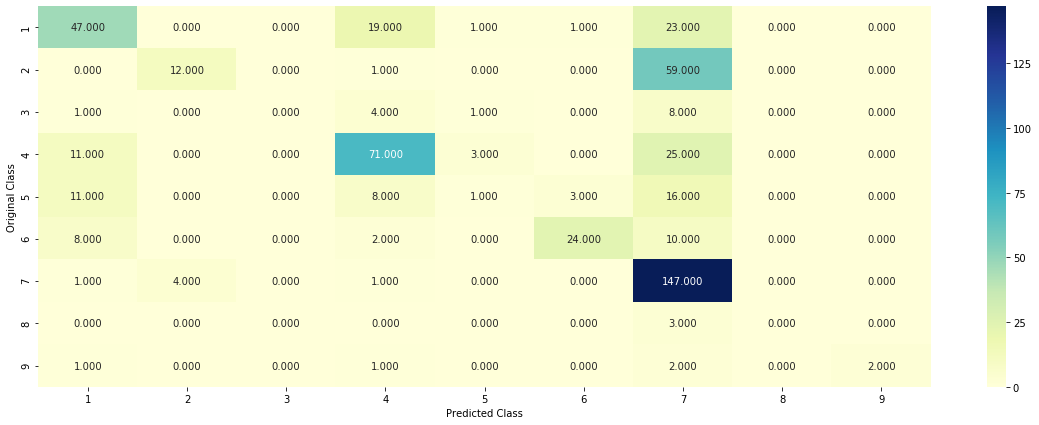

-------------------- Precision matrix (Columm Sum=1) --------------------


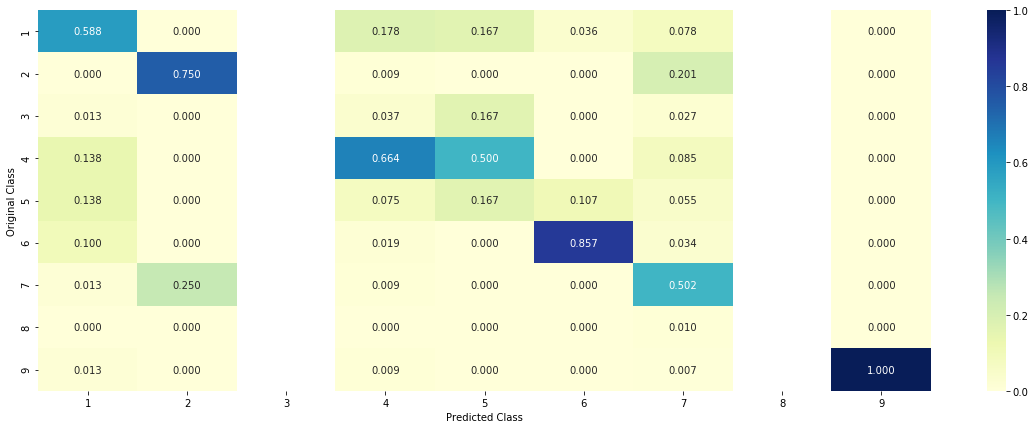

-------------------- Recall matrix (Row sum=1) --------------------


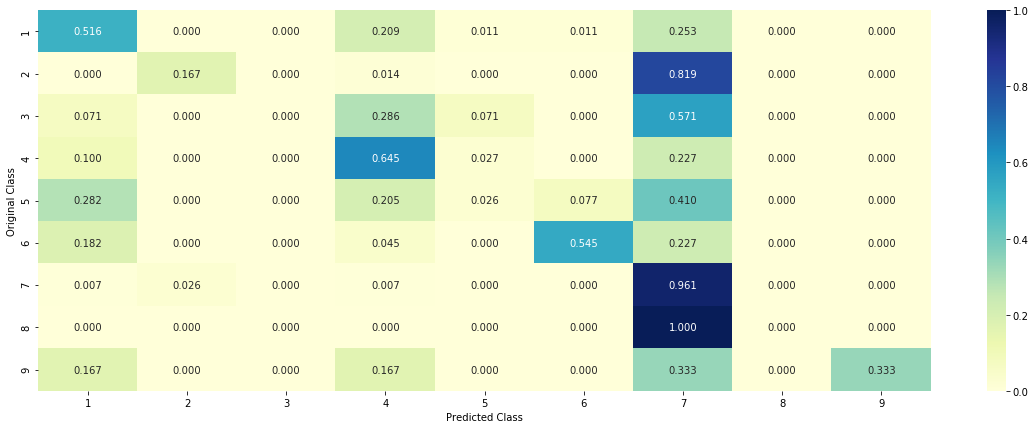

In [114]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)

sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_tfidf, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)

print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_tfidf)- cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_tfidf.toarray()))

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 1000.
- The test log loss by naive Bayes is 1.18.
- Number of misclassified points are 0.4285.

# KNN

## Hyper parameter tuning

for alpha = 5
Log Loss : 1.2941910205458698
for alpha = 11
Log Loss : 1.3477740079698028
for alpha = 15
Log Loss : 1.399721597832882
for alpha = 21
Log Loss : 1.45040678429071
for alpha = 31
Log Loss : 1.467997131093865
for alpha = 41
Log Loss : 1.4706001117753373
for alpha = 51
Log Loss : 1.4552817439550196
for alpha = 99
Log Loss : 1.4323727052622992


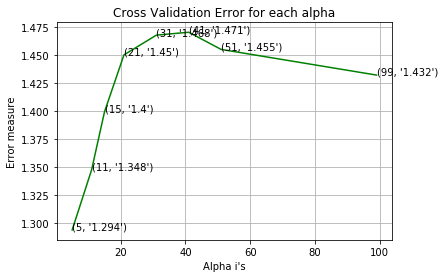

For values of best alpha =  5 The train log loss is: 0.9634390893102138
For values of best alpha =  5 The cross validation log loss is: 1.2941910205458698
For values of best alpha =  5 The test log loss is: 1.2638645736069705


In [115]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.2941910205458698
Number of mis-classified points : 0.4567669172932331
-------------------- Confusion matrix --------------------


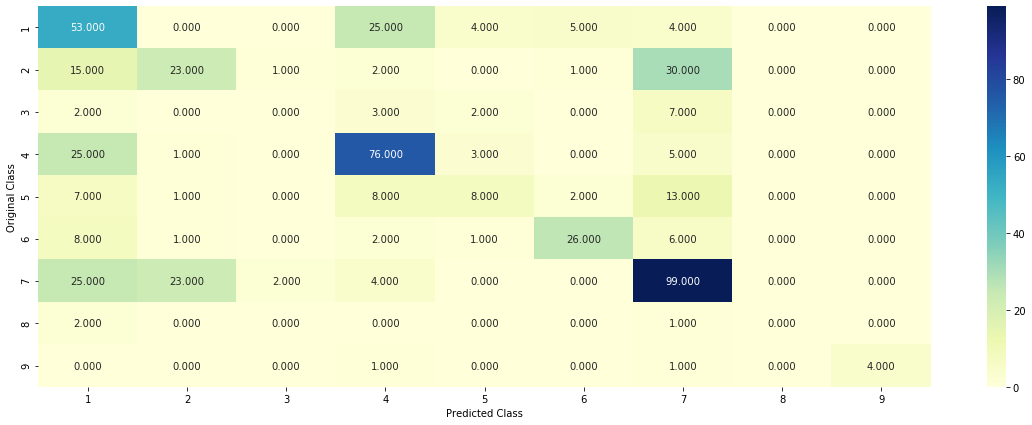

-------------------- Precision matrix (Columm Sum=1) --------------------


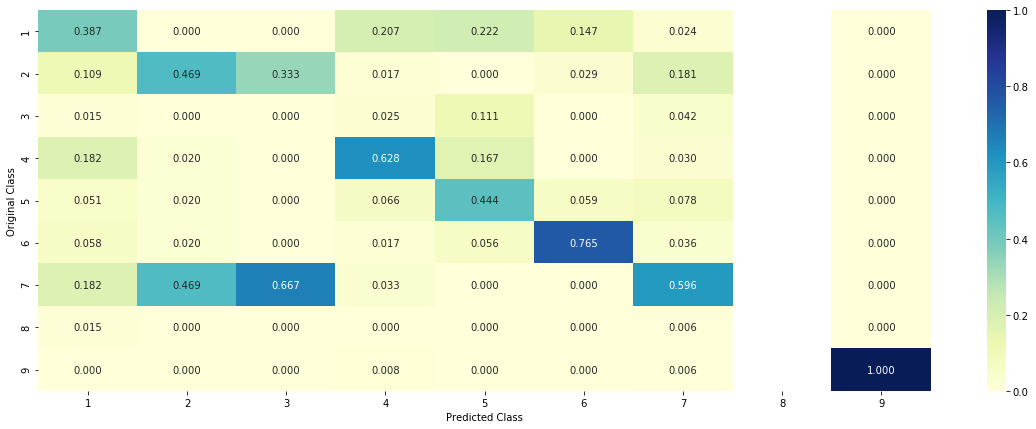

-------------------- Recall matrix (Row sum=1) --------------------


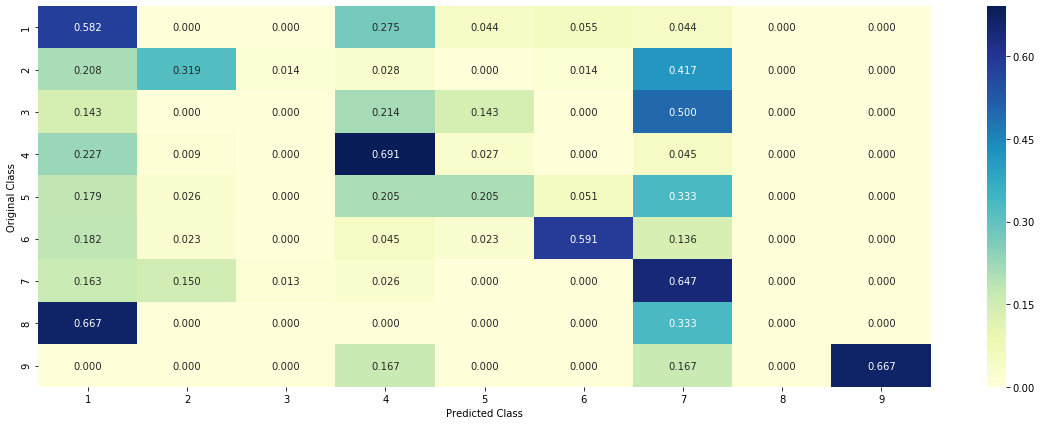

In [116]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best k value is 5.
- The test log loss by KNN is 1.26.
- Number of misclassified points are 0.4567.

# Logistic Regression with Class Balancing

## Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.2751024238615483
for alpha = 1e-05
Log Loss : 1.2393960476092876
for alpha = 0.0001
Log Loss : 1.0830510154512
for alpha = 0.001
Log Loss : 1.0739850377446598
for alpha = 0.01
Log Loss : 1.1438078247453767
for alpha = 0.1
Log Loss : 1.2481229489727215
for alpha = 1
Log Loss : 1.433919070546794
for alpha = 10
Log Loss : 1.4693911362074046
for alpha = 100
Log Loss : 1.4734067731654648


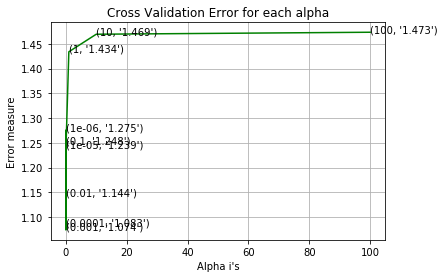

For values of best alpha =  0.001 The train log loss is: 0.5105594504248592
For values of best alpha =  0.001 The cross validation log loss is: 1.0739850377446598
For values of best alpha =  0.001 The test log loss is: 1.0113440638298266


In [117]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.0739850377446598
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


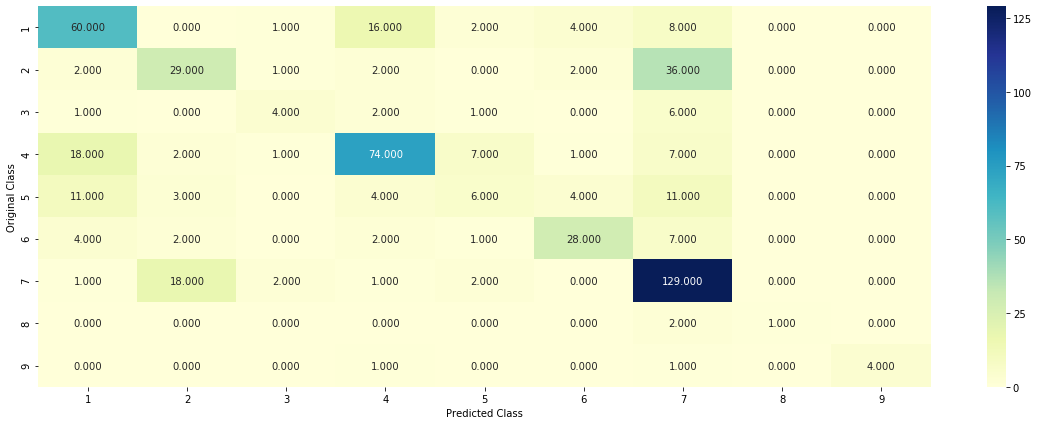

-------------------- Precision matrix (Columm Sum=1) --------------------


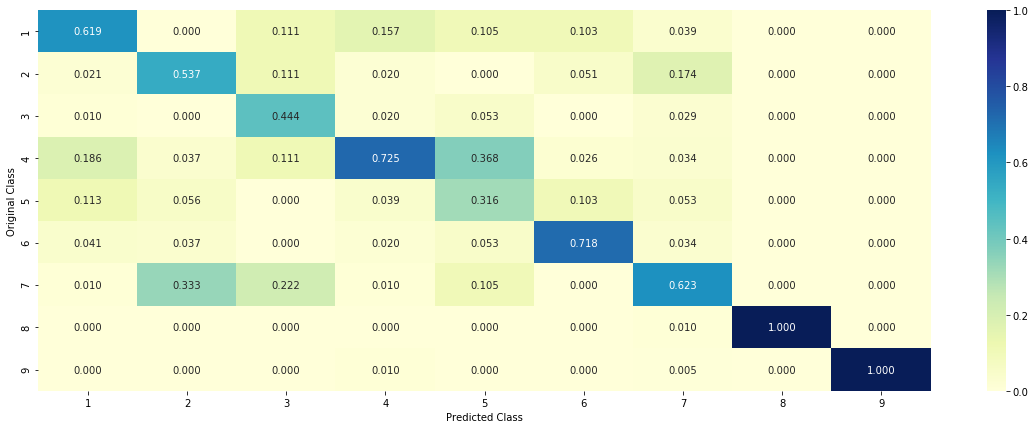

-------------------- Recall matrix (Row sum=1) --------------------


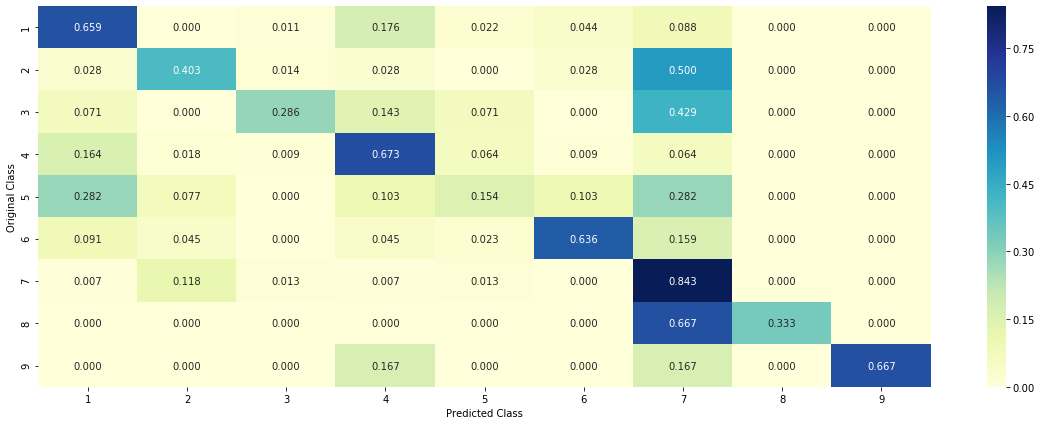

In [118]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.001.
- The test log loss by Logistic Regression with class balancing is 1.01.
- Number of misclassified points are 0.3703.

<h2> Logistic Regression Without Class balancing</h2>

<h3>Hyper paramter tuning</h3>

for alpha = 1e-06
Log Loss : 1.272531065193417
for alpha = 1e-05
Log Loss : 1.2459461384968082
for alpha = 0.0001
Log Loss : 1.0916561932098423
for alpha = 0.001
Log Loss : 1.0939303709450758
for alpha = 0.01
Log Loss : 1.1955109406897726
for alpha = 0.1
Log Loss : 1.2847854874007825
for alpha = 1
Log Loss : 1.4494429449654622


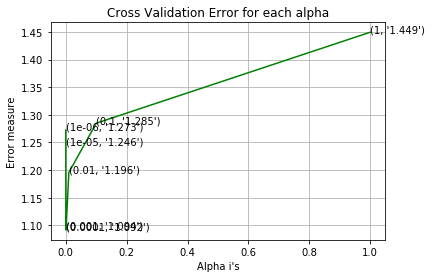

For values of best alpha =  0.0001 The train log loss is: 0.4759812532928805
For values of best alpha =  0.0001 The cross validation log loss is: 1.0916561932098423
For values of best alpha =  0.0001 The test log loss is: 1.0286615314703274


In [119]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.0916561932098423
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


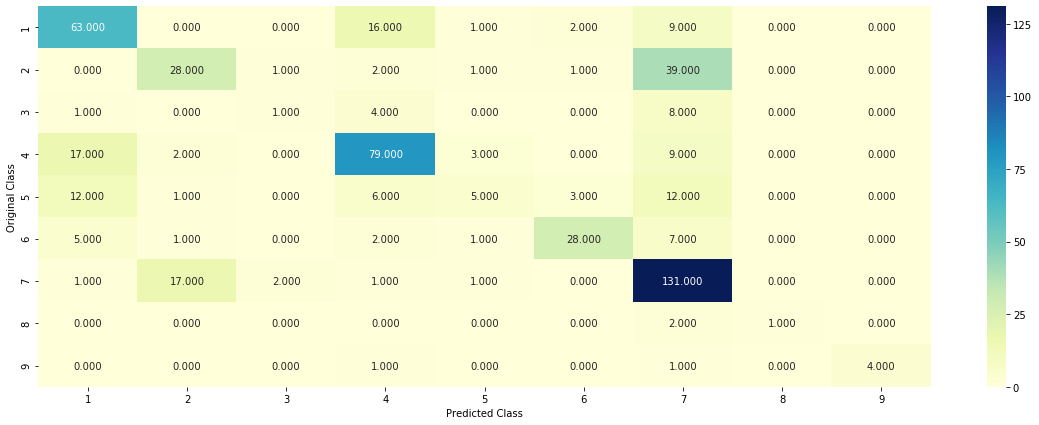

-------------------- Precision matrix (Columm Sum=1) --------------------


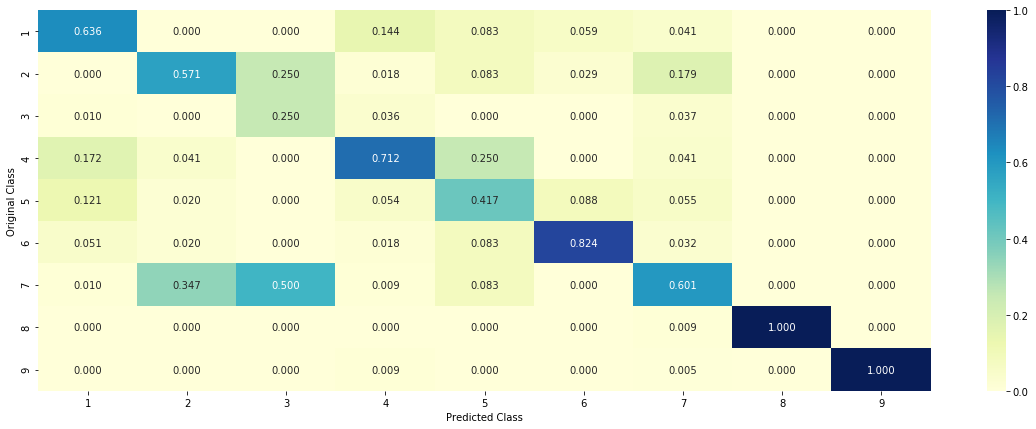

-------------------- Recall matrix (Row sum=1) --------------------


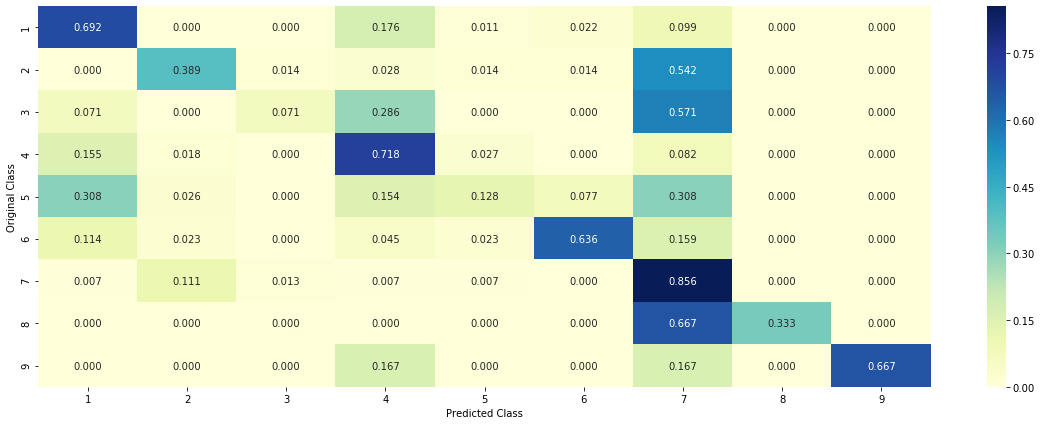

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.0001.
- The test log loss by Logistic Regression without class balancing is 1.02.
- Number of misclassified points are 0.3609.

<h2> Linear Support Vector Machines</h2>

<h3> Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2735936067612563
for C = 0.0001
Log Loss : 1.2000328846604487
for C = 0.001
Log Loss : 1.1024487725898398
for C = 0.01
Log Loss : 1.164610559812309
for C = 0.1
Log Loss : 1.3220900093065169
for C = 1
Log Loss : 1.4738461055677436
for C = 10
Log Loss : 1.474100505711623
for C = 100
Log Loss : 1.474100108095067


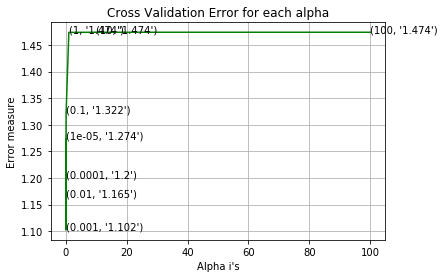

For values of best alpha =  0.001 The train log loss is: 0.5533588417656476
For values of best alpha =  0.001 The cross validation log loss is: 1.1024487725898398
For values of best alpha =  0.001 The test log loss is: 1.073887013337954


In [121]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>Testing model with best hyper parameters</h3>

Log loss : 1.1024487725898398
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


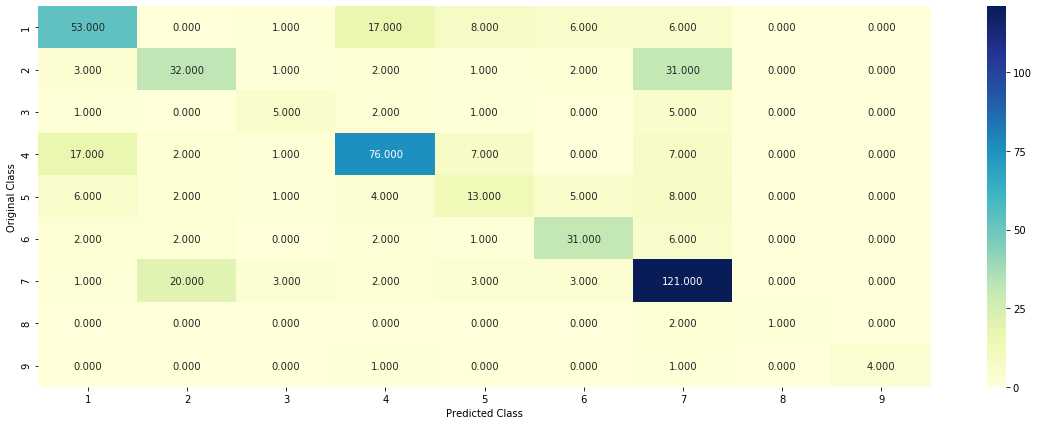

-------------------- Precision matrix (Columm Sum=1) --------------------


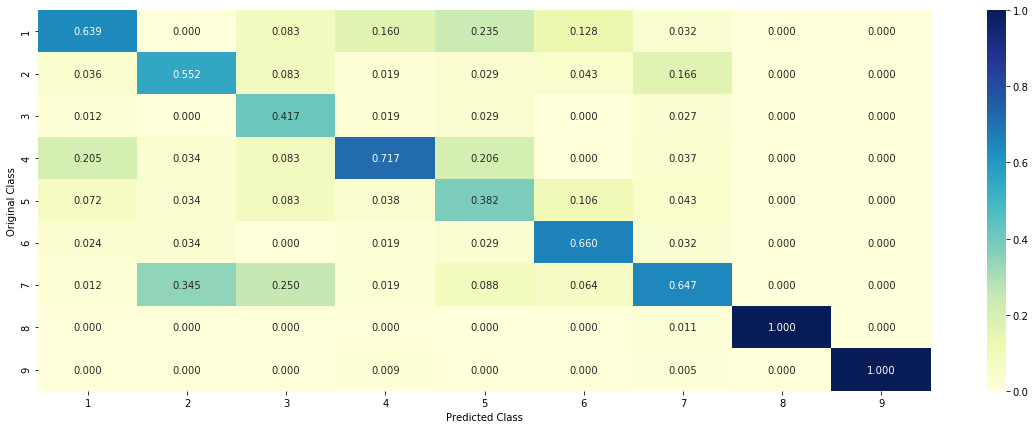

-------------------- Recall matrix (Row sum=1) --------------------


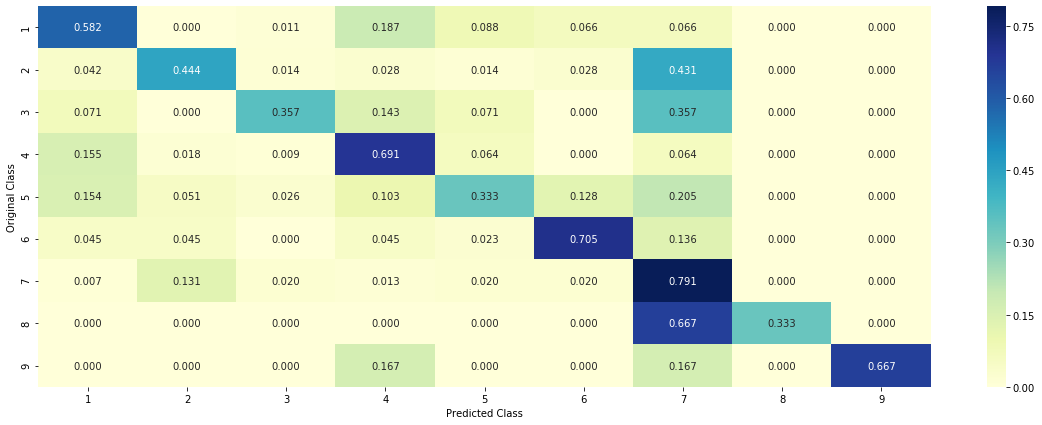

In [122]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,cv_x_tfidf,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.001.
- The test log loss by Linear SVM is 1.07.
- Number of misclassified points are 0.3684.

<h2>Random Forest Classifier</h2>

<h3> Hyper parameter tuning </h3>

In [123]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.268126835675337
for n_estimators = 100 and max depth =  10
Log Loss : 1.2005977274121666
for n_estimators = 200 and max depth =  5
Log Loss : 1.2556131580971834
for n_estimators = 200 and max depth =  10
Log Loss : 1.1916130891432741
for n_estimators = 500 and max depth =  5
Log Loss : 1.2511359532328394
for n_estimators = 500 and max depth =  10
Log Loss : 1.189059023548208
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2469193456463235
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1848191814169948
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2432647220946846
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1860459231997122
For values of best estimator =  1000 The train log loss is: 0.6583586380980803
For values of best estimator =  1000 The cross validation log loss is: 1.1848191814169948
For values of best estimator =  1000 The test log loss is: 1.1256824511651715


<h3> Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1848191814169946
Number of mis-classified points : 0.4116541353383459
-------------------- Confusion matrix --------------------


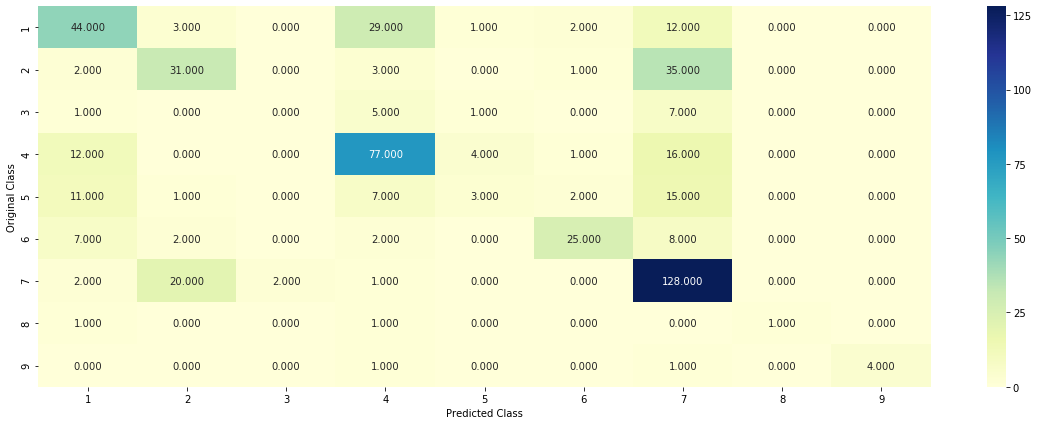

-------------------- Precision matrix (Columm Sum=1) --------------------


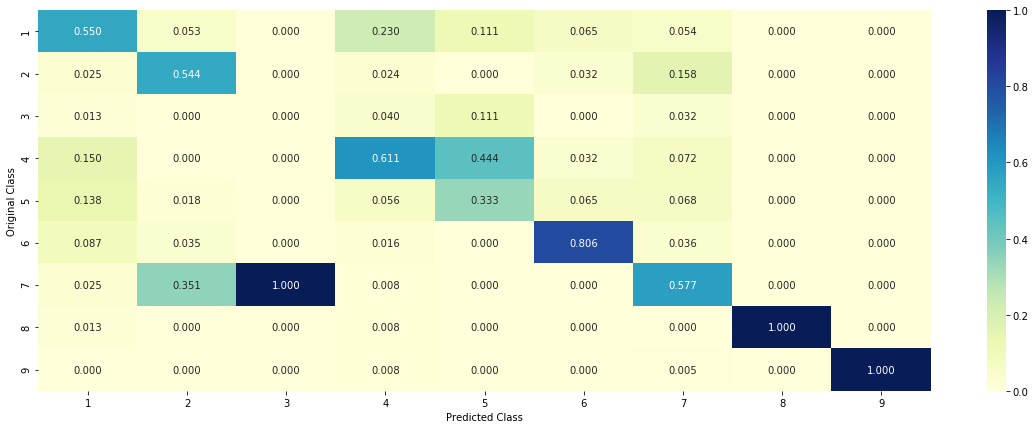

-------------------- Recall matrix (Row sum=1) --------------------


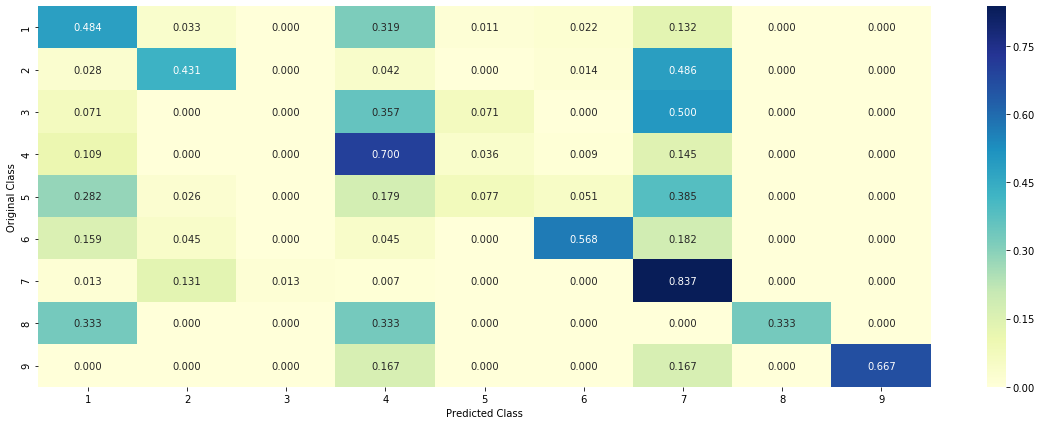

In [124]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,cv_x_tfidf,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 1000.
- The test log loss by Random Forest is 1.12.
- Number of misclassified points are 0.4116.

<h2>Stack the models </h2>

In [125]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tfidf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tfidf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tfidf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_tfidf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tfidf))))

sig_clf2.fit(train_x_tfidf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tfidf))))

sig_clf3.fit(train_x_tfidf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tfidf))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.08
Support vector machines : Log Loss: 1.47
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.718
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.325
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.233
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.531
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.924


<h3>Testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.4937010617579535
Log loss (CV) on the stacking classifier : 1.233320153124504
Log loss (test) on the stacking classifier : 1.1280079713846318
Number of missclassified point : 0.34135338345864663
-------------------- Confusion matrix --------------------


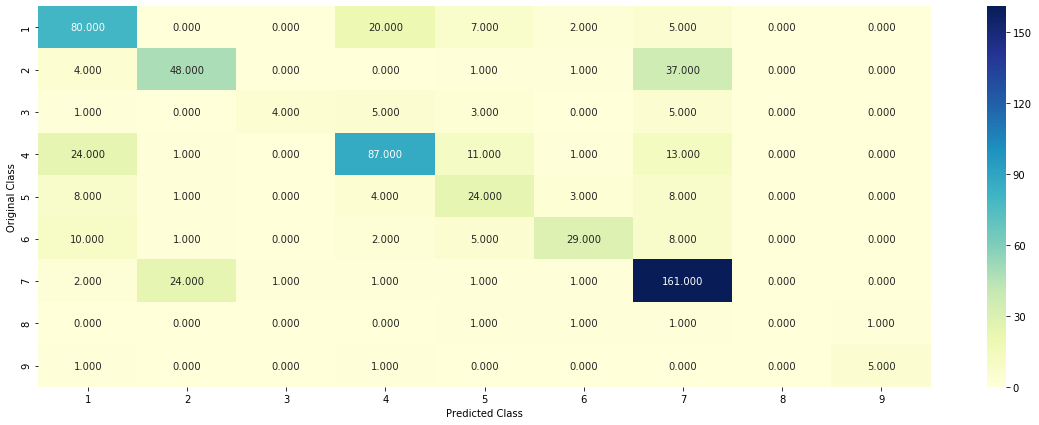

-------------------- Precision matrix (Columm Sum=1) --------------------


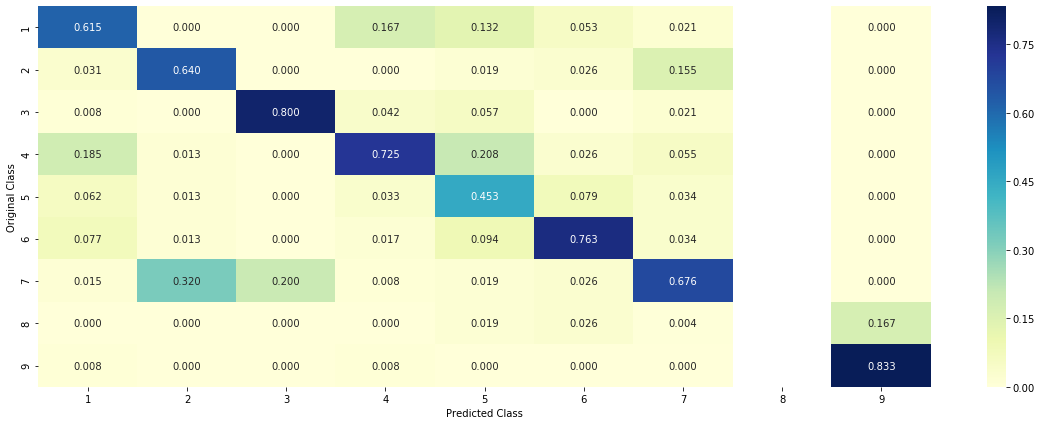

-------------------- Recall matrix (Row sum=1) --------------------


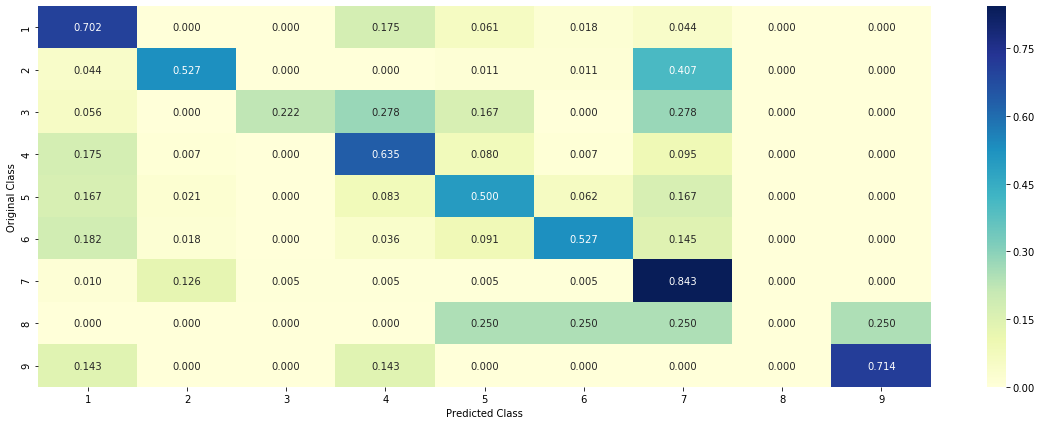

In [126]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_tfidf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tfidf))

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.1.
- The test log loss by Stacking classifier is 1.12.
- Number of misclassified points are 0.3413.

<h3>Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8162967469202848
Log loss (CV) on the VotingClassifier : 1.1367572286627716
Log loss (test) on the VotingClassifier : 1.1242854209145088
Number of missclassified point : 0.35789473684210527
-------------------- Confusion matrix --------------------


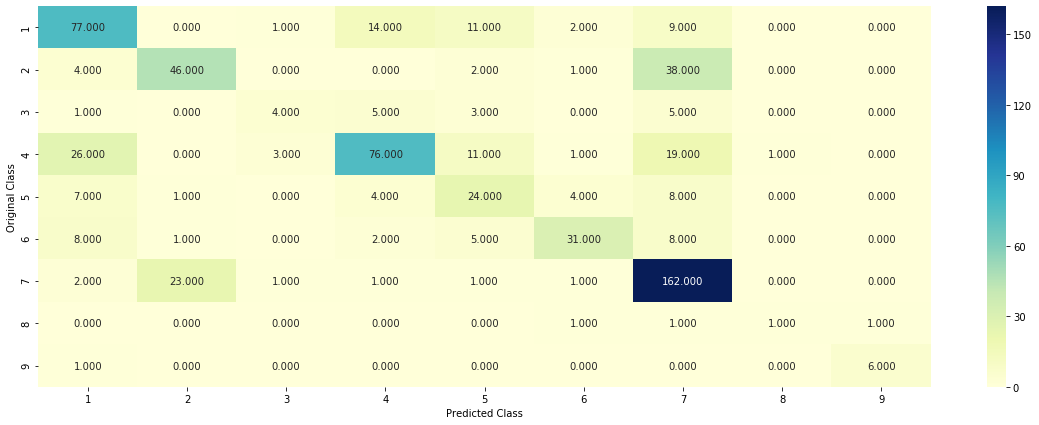

-------------------- Precision matrix (Columm Sum=1) --------------------


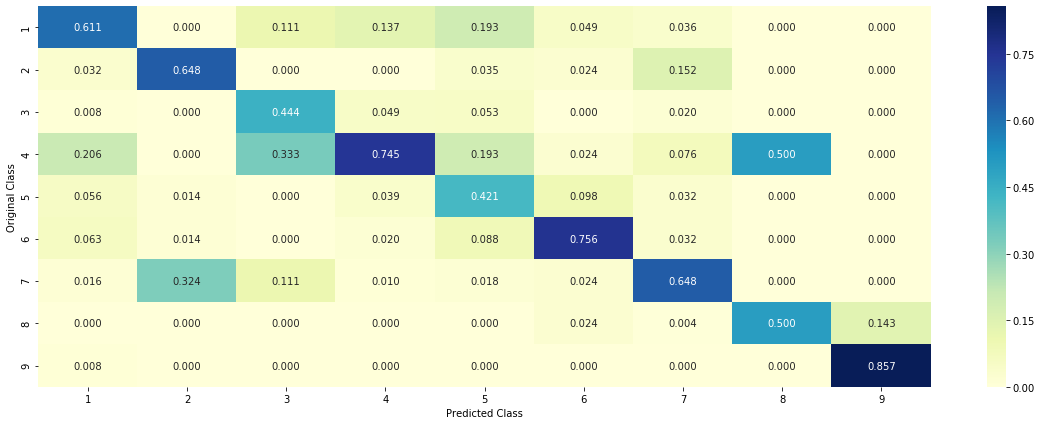

-------------------- Recall matrix (Row sum=1) --------------------


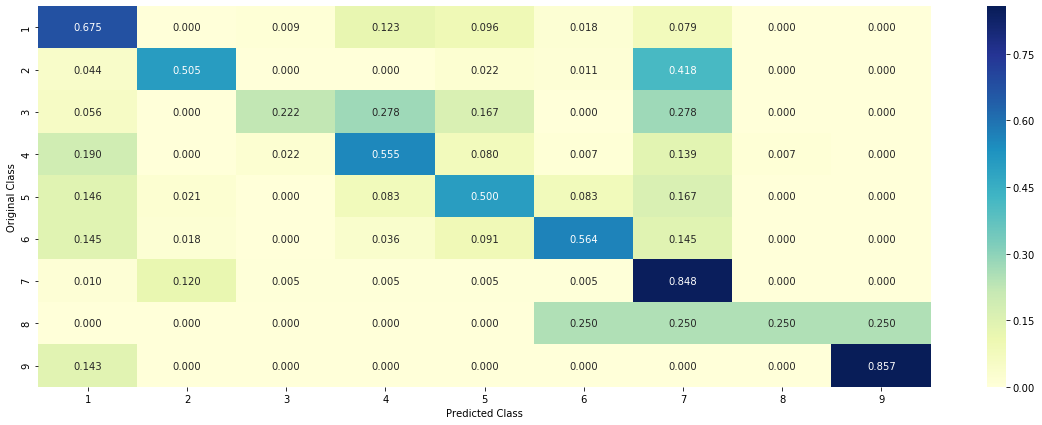

In [127]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_tfidf, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf))

<h1> <font color=blue> Observations </font></h1>

- The test log loss by Majority classifier is 1.12.
- Number of misclassified points are 0.3578.

# Task-2

## Using only top 1000 fetures based on Tf-idf values

In [128]:
text_vectorizer = TfidfVectorizer(min_df=3, max_features = 1000)

train_text_feature_tfidf = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features = text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [129]:
# Normalizing

train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

test_text_feature_tfidf = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)

# Merging all the features

In [130]:
train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [131]:
# Checking total datapoints in Train, Test and CV

print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in test data = ", test_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tfidf.shape)

(number of data points * number of features) in train data =  (2124, 3185)
(number of data points * number of features) in test data =  (665, 3185)
(number of data points * number of features) in cross validation data = (532, 3185)


# Applying Random Forest model 

## Hyper parameter tuning

In [132]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.260828361133113
for n_estimators = 100 and max depth =  10
Log Loss : 1.266732748705189
for n_estimators = 200 and max depth =  5
Log Loss : 1.2533695262425446
for n_estimators = 200 and max depth =  10
Log Loss : 1.256368665301526
for n_estimators = 500 and max depth =  5
Log Loss : 1.251235630383988
for n_estimators = 500 and max depth =  10
Log Loss : 1.2547795011864793
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2490392126421068
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2532326284257604
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2471987654446224
for n_estimators = 2000 and max depth =  10
Log Loss : 1.2523481923475053
For values of best estimator =  2000 The train log loss is: 0.8632800716702296
For values of best estimator =  2000 The cross validation log loss is: 1.2471987654446224
For values of best estimator =  2000 The test log loss is: 1.1856445832766112


<h3> Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.2471987654446224
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


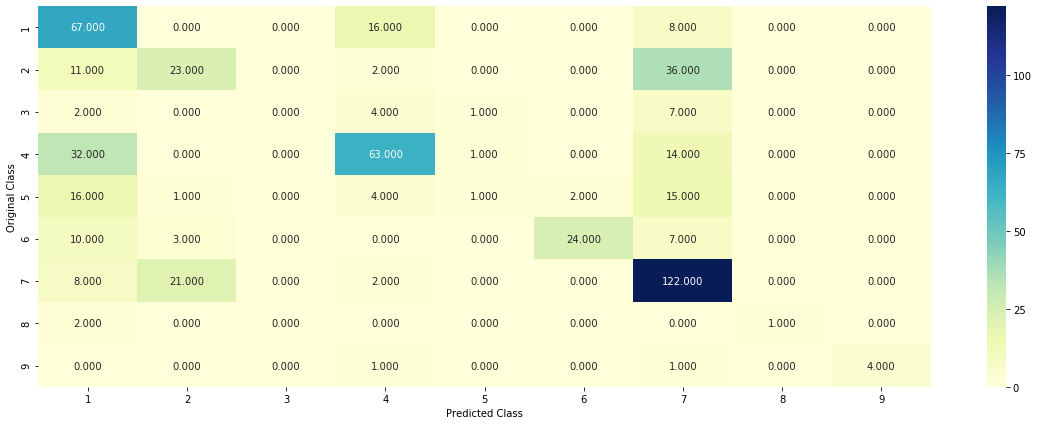

-------------------- Precision matrix (Columm Sum=1) --------------------


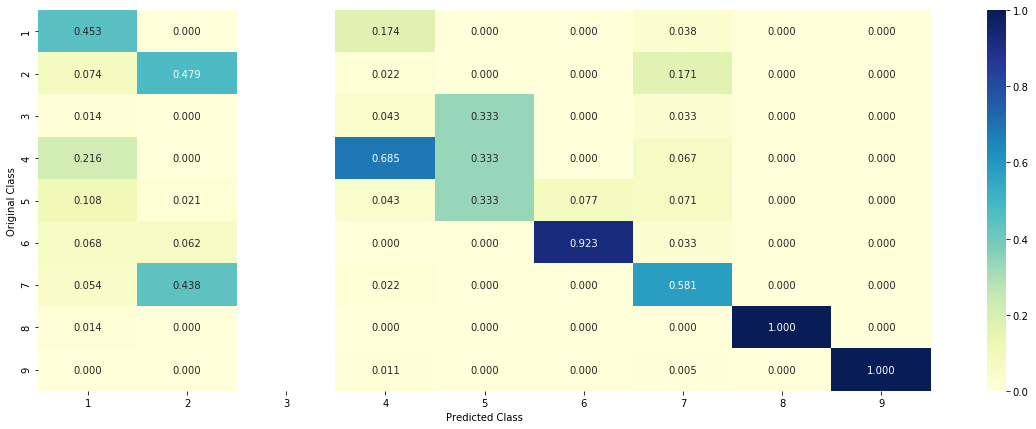

-------------------- Recall matrix (Row sum=1) --------------------


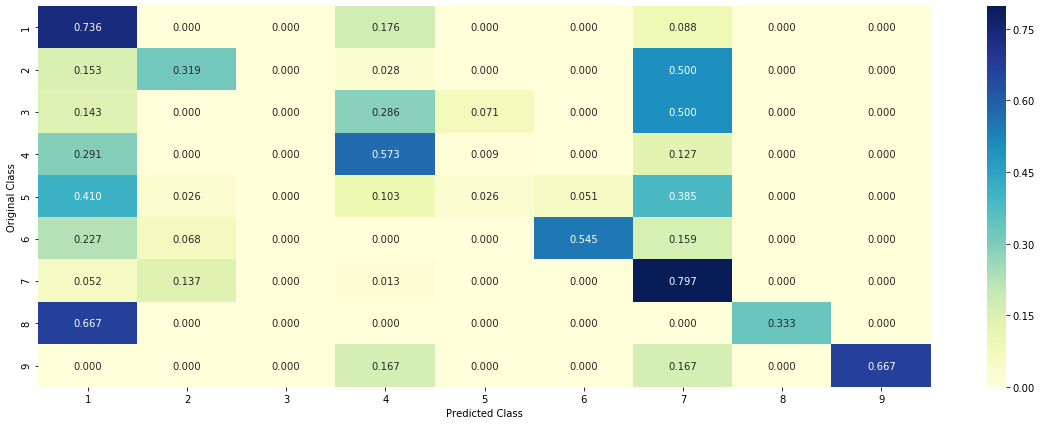

In [133]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,cv_x_tfidf,cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 2000.
- The test log loss by Random Forest is 1.18.
- Number of misclassified points are 0.4266.

# Task-3

## Applying LR with both uni-grams and bi-grams

In [134]:
text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2))

train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 789389


In [135]:
# Normalizing

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

## Merging all the features

In [136]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [137]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 791574)
(number of data points * number of features) in test data =  (665, 791574)
(number of data points * number of features) in cross validation data = (532, 791574)


<h2> Applying Logistic Regression with Class Balancing</h2>

<h3> Hyper parameter tuning </h3>

for alpha = 1e-06
Log Loss : 1.543939548813537
for alpha = 1e-05
Log Loss : 1.515462677813077
for alpha = 0.0001
Log Loss : 1.4308402415533696
for alpha = 0.001
Log Loss : 1.2025152836307598
for alpha = 0.01
Log Loss : 1.1894389676239001
for alpha = 0.1
Log Loss : 1.2432084375239036
for alpha = 1
Log Loss : 1.3111301978049443
for alpha = 10
Log Loss : 1.3595365979607825
for alpha = 100
Log Loss : 1.3711890568298912


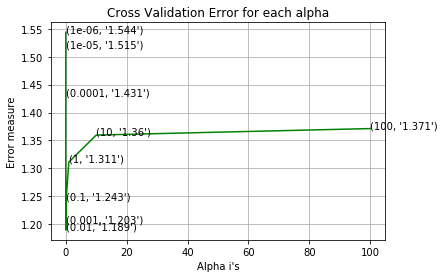

For values of best alpha =  0.01 The train log loss is: 0.6730755587777723
For values of best alpha =  0.01 The cross validation log loss is: 1.1894389676239001
For values of best alpha =  0.01 The test log loss is: 1.1352643045663067


In [138]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3> Testing the model with best hyper paramters</h3>

Log loss : 1.1894389676239001
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


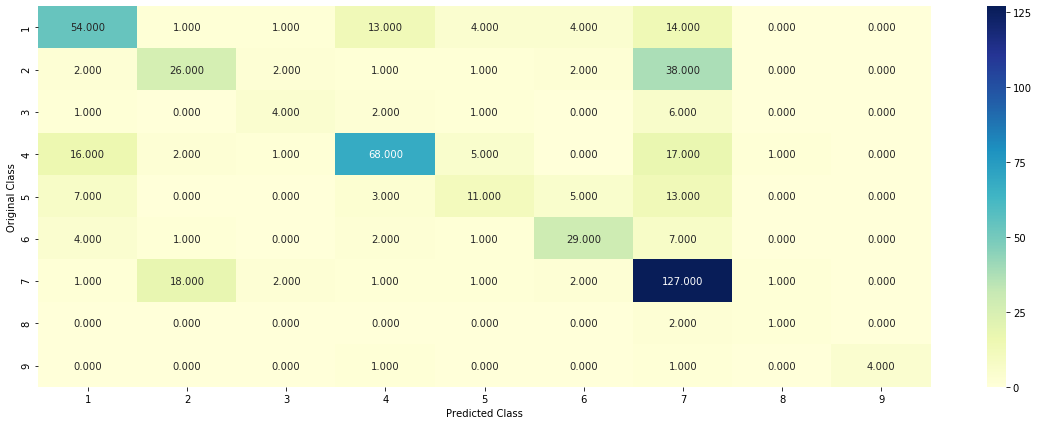

-------------------- Precision matrix (Columm Sum=1) --------------------


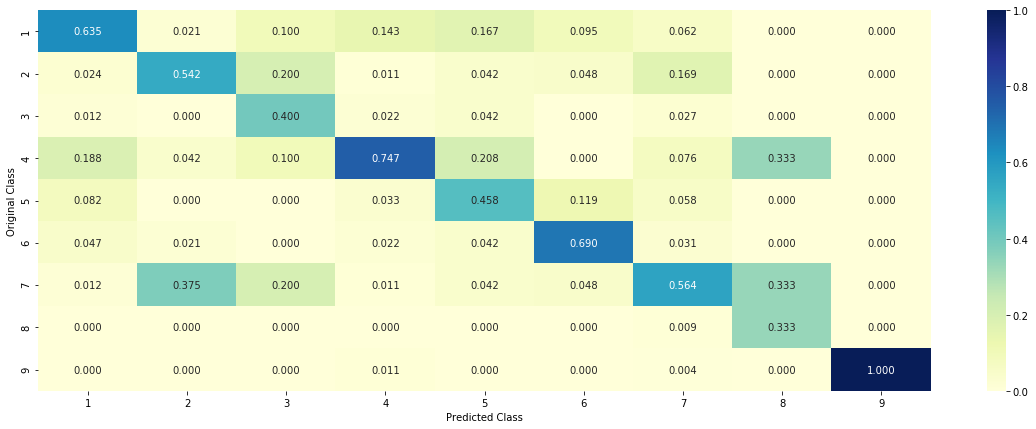

-------------------- Recall matrix (Row sum=1) --------------------


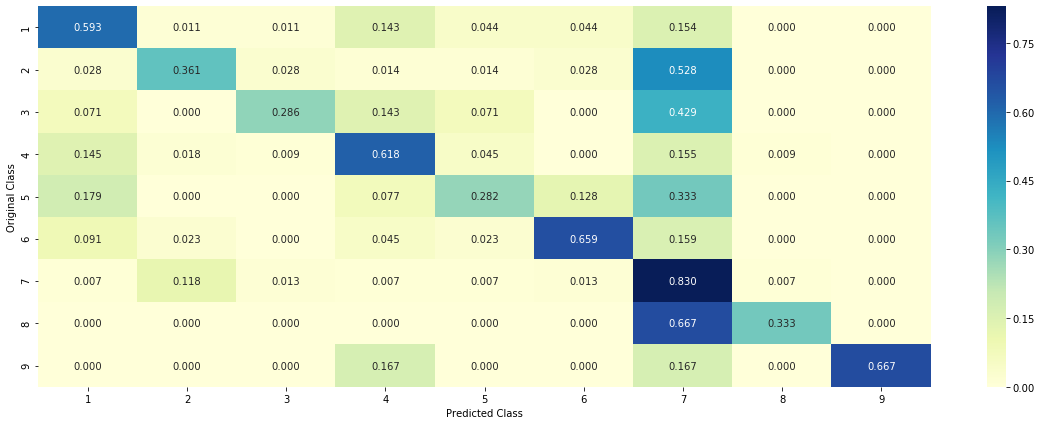

In [139]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.01.
- The test log loss by Logistic Regression is 1.13.
- Number of misclassified points are 0.3909.

# Task 4

## Using any feature engineering technique to reduce the log-loss

In [149]:
# At first I have have tried Topic extraction for feature engineering but I didn't get satisfactory results
# https://medium.com/analytics-vidhya/personalized-cancer-diagnosis-3d6f09a6b8c9

text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 4), max_features=2000)

train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 2000


In [150]:
# Normalizing

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [151]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [152]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 4185)
(number of data points * number of features) in test data =  (665, 4185)
(number of data points * number of features) in cross validation data = (532, 4185)


for alpha = 1e-06
Log Loss : 1.1153880194959058
for alpha = 1e-05
Log Loss : 1.0514235281766164
for alpha = 0.0001
Log Loss : 1.0058467708299583
for alpha = 0.001
Log Loss : 1.0525565939054393
for alpha = 0.01
Log Loss : 1.2795530875185093
for alpha = 0.1
Log Loss : 1.7438073084429748
for alpha = 1
Log Loss : 1.7916924305648578
for alpha = 10
Log Loss : 1.7958845811502266
for alpha = 100
Log Loss : 1.7963241371379632


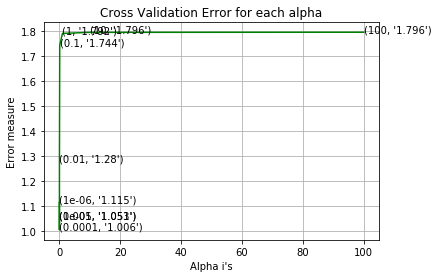

For values of best alpha =  0.0001 The train log loss is: 0.39124874063290827
For values of best alpha =  0.0001 The cross validation log loss is: 1.0058467708299583
For values of best alpha =  0.0001 The test log loss is: 0.965515596120808


In [153]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))

plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0058467708299583
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


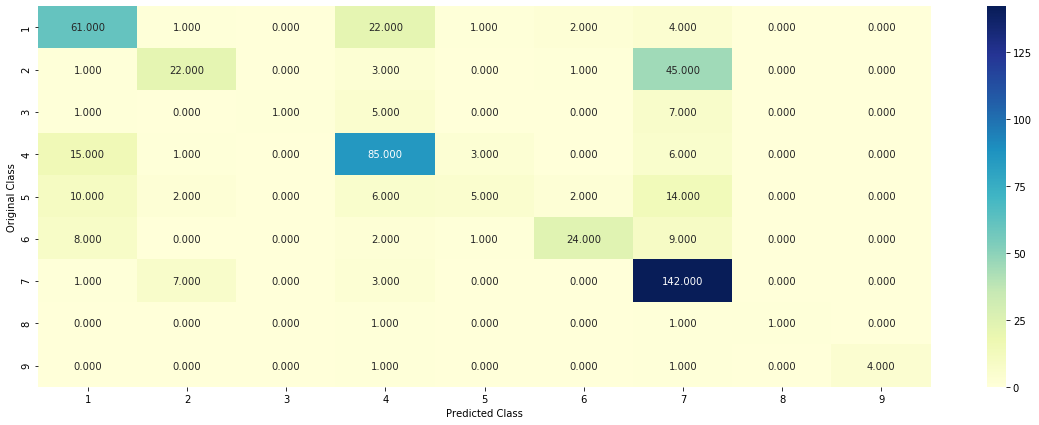

-------------------- Precision matrix (Columm Sum=1) --------------------


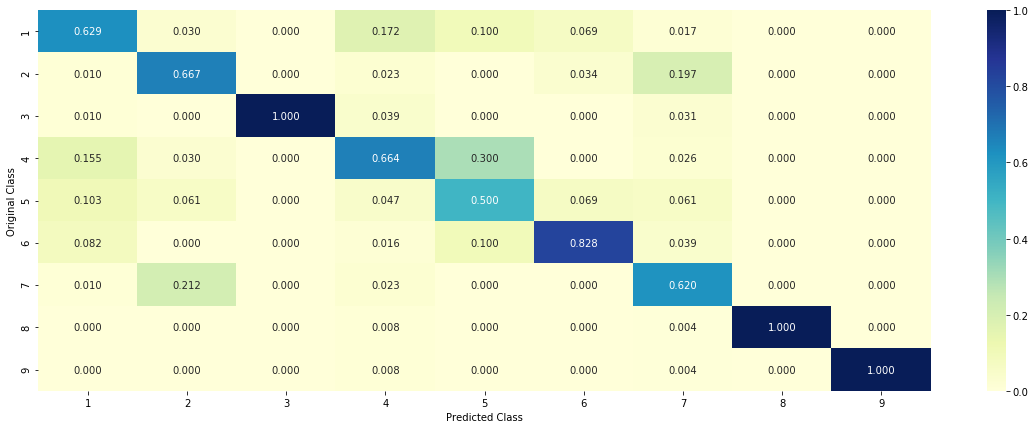

-------------------- Recall matrix (Row sum=1) --------------------


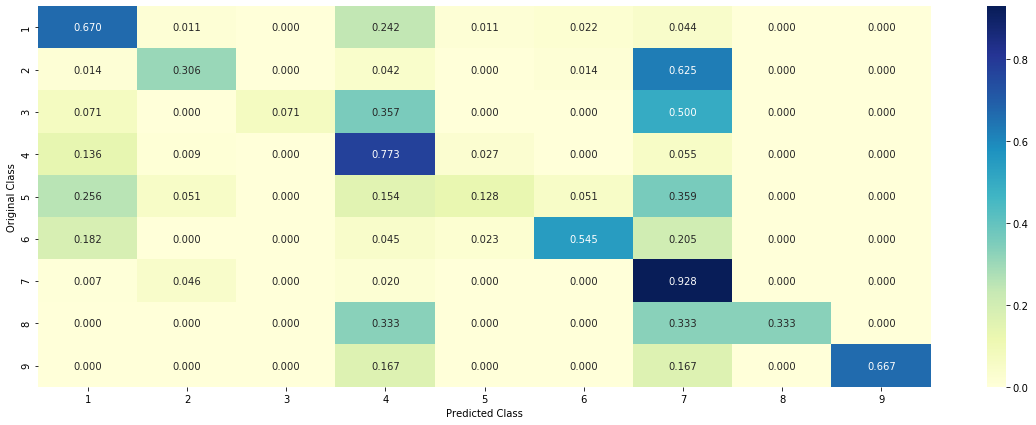

In [154]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h1> <font color=blue> Observations </font></h1>

- The best alpha value is 0.0001.
- The test log loss by Logistic Regression is 0.965.
- Number of misclassified points are 0.3515.

# Showing results with the Preety table

In [2]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ['No.', 'Model Name', 'Text Technique', 'Test Log-Loss', 'Misclassified Points']
pt.add_row(["0","Random", "BoW", "2.47", "-"])
pt.add_row(["1","Naive Bayes", "BoW", "1.27", "39.28%"])
pt.add_row(["2","KNN", "BoW", "1.07", "38.34%"])
pt.add_row(["3","LR with class balancing", "BoW", "1.04", "37.03%"])
pt.add_row(["4","LR without class balancing", "BoW", "1.05", "37.21%"])
pt.add_row(["5","Linear SVM", "BoW", "1.11", "36.27%"])
pt.add_row(["6","RF with onehot encoding", "BoW", "1.14", "40.22%"])
pt.add_row(["7","RF with response coding", "BoW", "1.30", "55.82%"])
pt.add_row(["8","Stacking Classifier", "BoW", "1.12", "33.83%"])
pt.add_row(["9","Maximum voting Classifier", "BoW", "1.17", "34.58%"])

pt.add_row(["\n","\n", "\n", "\n", "\n"])

pt.add_row(["10","Naive Bayes", "Tf-Idf", "1.18", "42.85%"])
pt.add_row(["11","KNN", "Tf-Idf", "1.26", "45.67%"])
pt.add_row(["12","LR with class balancing", "Tf-Idf", "1.01", "37.03%"])
pt.add_row(["13","LR without class balancing", "Tf-Idf", "1.02", "36.09%"])
pt.add_row(["14","Linear SVM", "Tf-Idf", "1.07", "36.84%"])
pt.add_row(["15","RF with onehot encoding", "Tf-Idf", "1.12", "41.16%"])
pt.add_row(["16","Stacking Classifier", "Tf-Idf", "1.12", "34.13%"])
pt.add_row(["17","Maximum voting Classifier", "Tf-Idf", "1.12", "35.78%"])

pt.add_row(["\n","\n", "\n", "\n", "\n"])

pt.add_row(["18","RF", "Tf-Idf with top 1000 ft", "1.18", "42.66%"])
pt.add_row(["19","LR with unigram & Bigram", "BoW", "1.13", "39.09%"])
pt.add_row(["20","LR", "Feature Engineering", "0.965", "35.15%"])

print(pt)

+-----+----------------------------+-------------------------+---------------+----------------------+
| No. |         Model Name         |      Text Technique     | Test Log-Loss | Misclassified Points |
+-----+----------------------------+-------------------------+---------------+----------------------+
|  0  |           Random           |           BoW           |      2.47     |          -           |
|  1  |        Naive Bayes         |           BoW           |      1.27     |        39.28%        |
|  2  |            KNN             |           BoW           |      1.07     |        38.34%        |
|  3  |  LR with class balancing   |           BoW           |      1.04     |        37.03%        |
|  4  | LR without class balancing |           BoW           |      1.05     |        37.21%        |
|  5  |         Linear SVM         |           BoW           |      1.11     |        36.27%        |
|  6  |  RF with onehot encoding   |           BoW           |      1.14     |    

# Precedure Followed

<h3> <font color=red> Problem Statement:  </font></h3> 

- Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

<b> Step 1 :  </b> We have 2 files, one file is having ID, Gene, Variation, Class and the other file is having ID, text. So first I have cleaned the text data in the second file so that I can conbine both the files based on ID. Based on these features we need to predict in which class a particular datapoint belongs to.

<b> Step 2 : </b> After Merging both the files now we have a final file which contains ID, Gene, Variation, Class, Text.
Now I have checked the type of my dataset like is it balanced data or Imbalanced data. I have checked that through checking the distribution of classes. I get to know that the dataset we have is imbalanced dataset. dataset have Classes 7, 4, 1 and 2 as majority classes and classes 3, 4, 8, 9 as minority classes.

<b> Step 3 : </b>  Before procedding further we need to check the worst log loss that our model can have. We can check the worst log loss by building a Random model. The worst logloss achieved on Random model is 2.47.

<b> Step 4 : </b> Now since we have very few features I have performed Univariate Analysis on each feature to know that how each feature perform in predicting the class Label. According to the results that I got Gene and Text features are very important features because by using them only we can see the significant decrease in Log loss. variation feature is usefull but not as much as compare to other features.

<b> Step 5 : </b> After doing Univariate Analysis I have applied different Machine learning algorithms such as Naive Bayes, KNN, Logistic Regression, Random Forest, etc. While applying models I have checked the multiclass log loss that I have achieved by that model and along with that I am also printing the No. of misclassified points. To get better understanding I have also plotted Confusion Matrix, Recall Matrix, Precision Matrix. 

<b> Step 6 : </b> Among all the models that I have tried I have got best results in Logistic Regression ( Multiclass log loss - 1.04) 

<b> Step 7 : </b> We also need to take care of the Interpretability, So while building machine learning model I have also showed why my model is classifing the particular point to that class. In this problem interpretability matters a lot because the researcher can get to know why our model is predicting this specific output.

<b> Step 8 : </b> Now After applying BoW we have tried to use the Tf-Idf Vectorizer instead of BagOfWords to see the changes we get in our outcome. From the above Preetytabel we can see that the Models that I have built using Tf-Idf Vectorizer have better log loss as compare to model with BoW. But In Tf-Idf models the No. of misclassified points are slightly more than BoW models.

<b> Step 9 : </b> To reduce the log loss I have tried to use only top 1000 features based on their IDF values then I have also tried to use both Uni-grams and Bi-grams to see what results I am getting. But the results are not quite satisfactory.

<b> Step 10 : </b> At last I needed to reduce the log loss less than 1.0. At first I have tried Topic Extraction but I dod not get log loss below 1.0. So to achieve log loss less than 1 I have set the ngram range to (1, 4) which means it will consider Uni-gram, Bi-gram, Tri-gram, 4-gram. If we increase the number of words while converting text into matrix then by increasing we might get more insight that Uni-gram. And I have also selected top 2000 features. Finally I got the Log loss of 0.965.